### Analytical Question :
#### To acquire a discrete latent representation, we integrate concepts from vector quantization (VQ). Employing the VQ method enables the model to overcome challenges associated with "posterior collapse." This phenomenon, observed in the Variational Autoencoder (VAE) framework, involves the neglect of latent variables when coupled with a potent autoregressive decoder. By incorporating VQ, the model avoids this issue.

#### Furthermore, the discrete latent representations, when combined with an autoregressive prior, empower the model to generate high-quality images, videos, and speech.

In [3]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=256, shuffle=False)

In [7]:
import torch
import torch.nn as nn

class codebook(nn.Module):
    def __init__(self, codebook_dim, codebook_size):
        super(codebook, self).__init__()
        self.codebook = nn.Embedding(codebook_size, codebook_dim)
        with torch.no_grad():
            self.codebook.weight.fill_(0.5)

    def forward(self, input_vector):
        distances = torch.norm(input_vector[:, :, None, :] - self.codebook.weight[None, :, :], dim=-1)
        indices = torch.argmin(distances, dim=-1)
        quantized_vector = self.codebook.weight[indices].view(input_vector.shape)
        return quantized_vector

class VQVAE(nn.Module):
    def __init__(self, input_channel, channel_sizes, latent_dim, codebook_size, codebook_dim):
        super(VQVAE, self).__init__()
        self.codebook_dim = codebook_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channel, channel_sizes[0],kernel_size=7, stride=4, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(channel_sizes[0]),
            nn.Conv2d(channel_sizes[0], channel_sizes[1], kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_sizes[1], latent_dim * codebook_dim, kernel_size=3, stride=2, padding=0),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim * codebook_dim, channel_sizes[1], kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_sizes[1], channel_sizes[0], kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(channel_sizes[0]),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_sizes[0], input_channel, kernel_size=7, stride=4, padding=2, output_padding=1),
            nn.Sigmoid()
        )

        self.codebook = codebook(codebook_dim, codebook_size)

    def forward(self, x):
        x = self.encoder(x)

        if len(x.shape) > 3:
            latent_vector = x.view(x.size(0), self.latent_dim, 1, self.codebook_dim).squeeze(-2)
            quantized_vector = self.codebook(latent_vector)
            x = latent_vector + (self.codebook(latent_vector) - latent_vector).detach()
            x = x.view(x.size(0), self.latent_dim * self.codebook_dim, 1, 1)
        else:
            latent_vector = x.view(1, self.latent_dim, 1, self.codebook_dim)
            quantized_vector = self.codebook(latent_vector)
            x = latent_vector + (quantized_vector - latent_vector).detach()
            x = x.squeeze(0).view(self.latent_dim * self.codebook_dim, 1, 1)

        x = self.decoder(x)

        return x, latent_vector, quantized_vector


Epoch [1/10], Training Loss: 0.175780
Epoch [1/10], Validation Loss: 0.127449


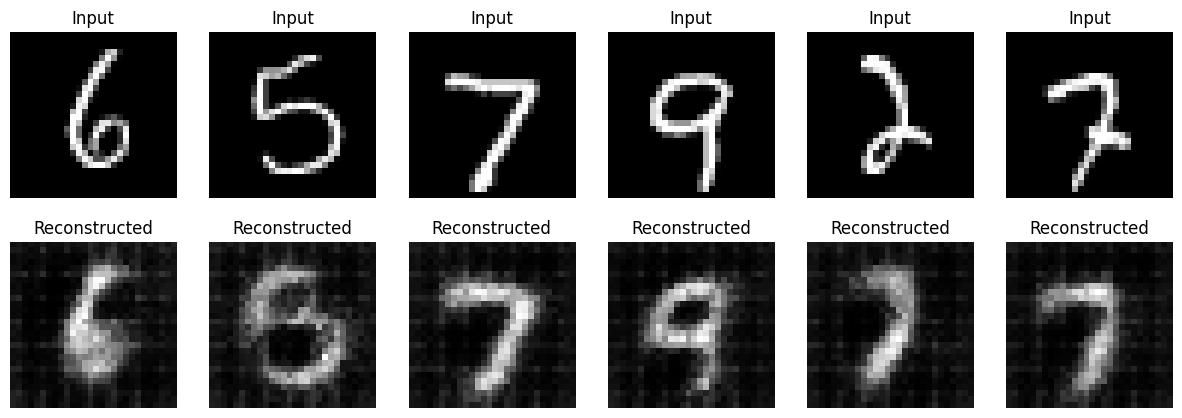

Epoch [2/10], Training Loss: 0.100997
Epoch [2/10], Validation Loss: 0.089247


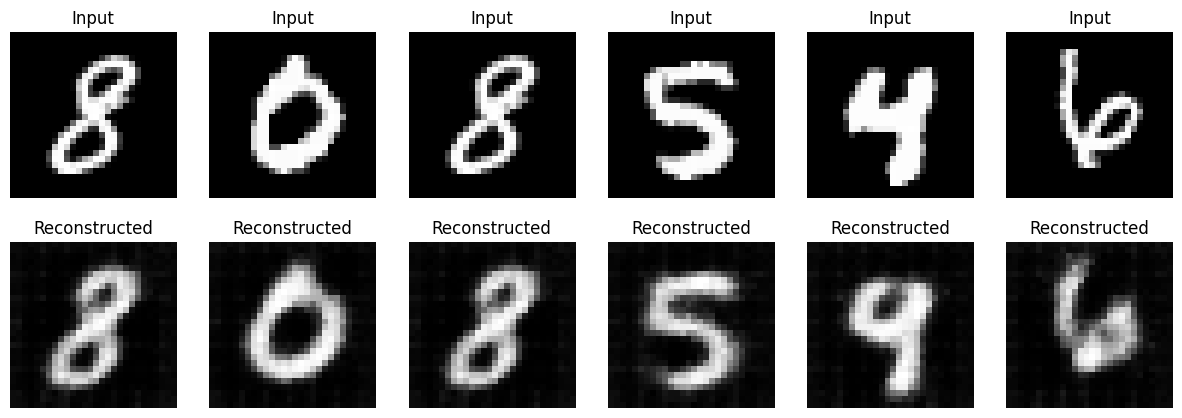

Epoch [3/10], Training Loss: 0.080991
Epoch [3/10], Validation Loss: 0.078526


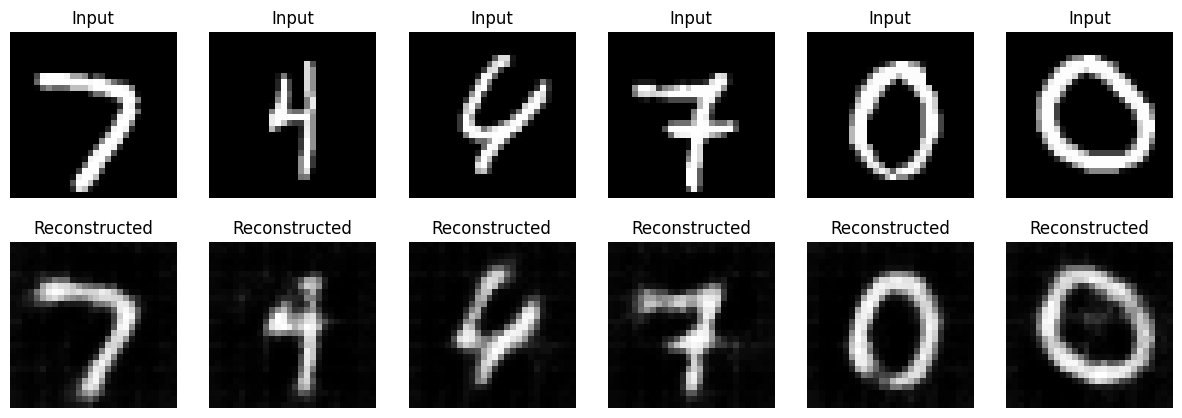

Epoch [4/10], Training Loss: 0.074264
Epoch [4/10], Validation Loss: 0.074705


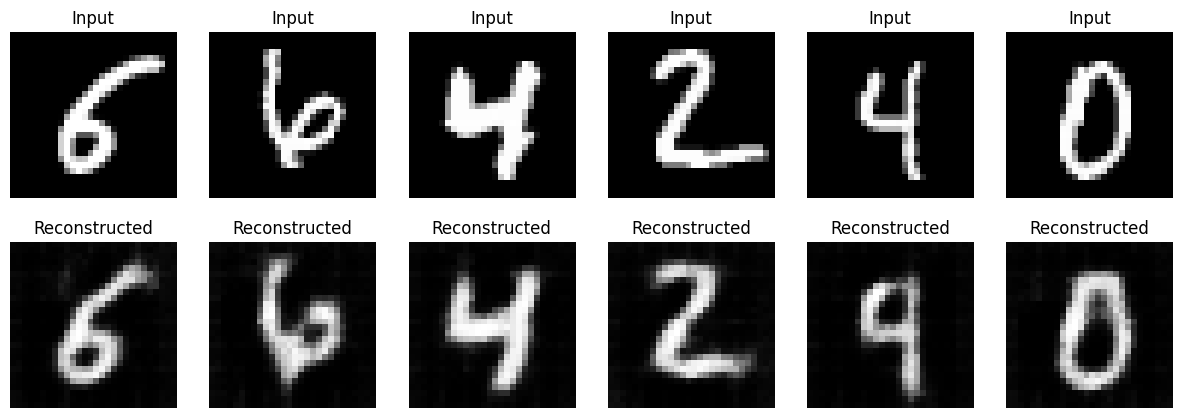

Epoch [5/10], Training Loss: 0.072062
Epoch [5/10], Validation Loss: 0.073498


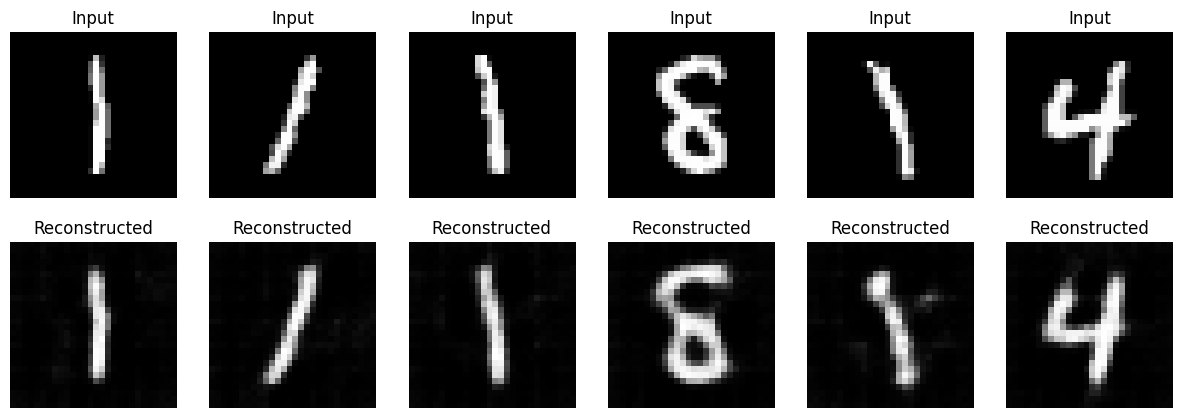

Epoch [6/10], Training Loss: 0.071718
Epoch [6/10], Validation Loss: 0.073751


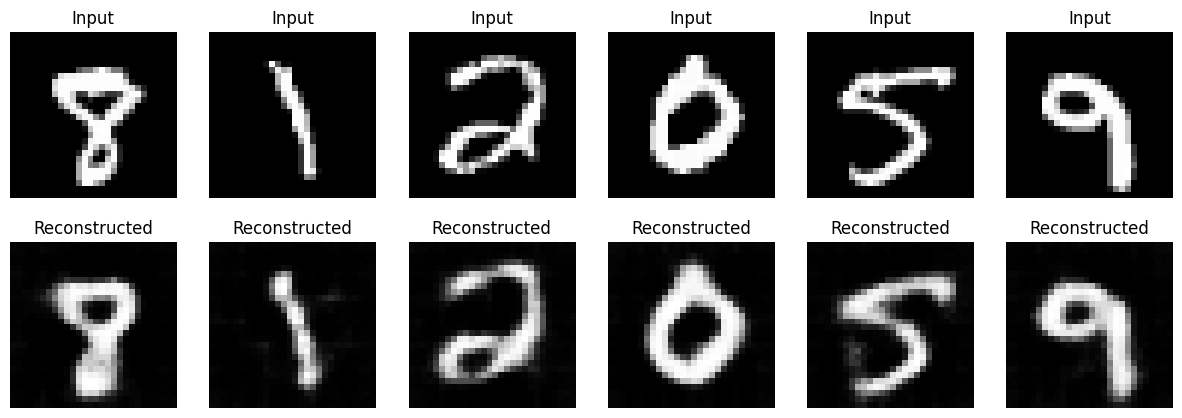

Epoch [7/10], Training Loss: 0.071989
Epoch [7/10], Validation Loss: 0.073998


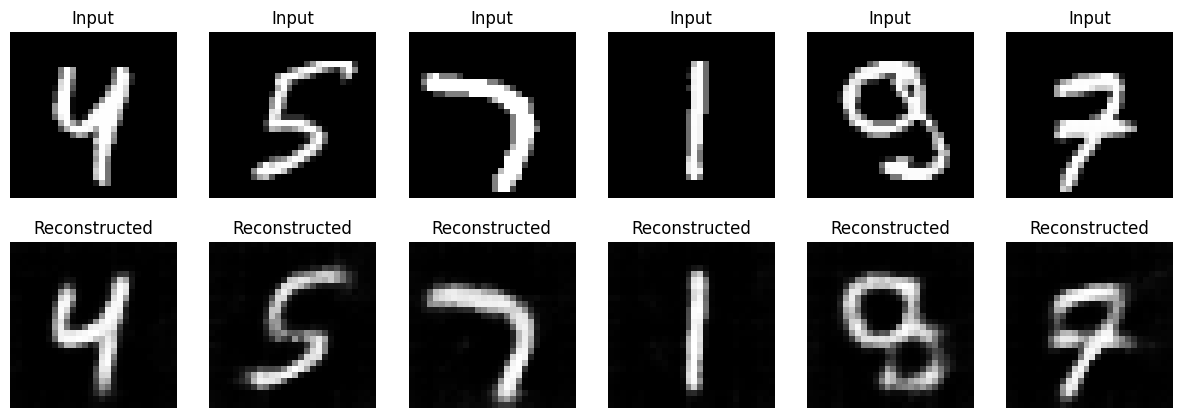

Epoch [8/10], Training Loss: 0.072245
Epoch [8/10], Validation Loss: 0.073965


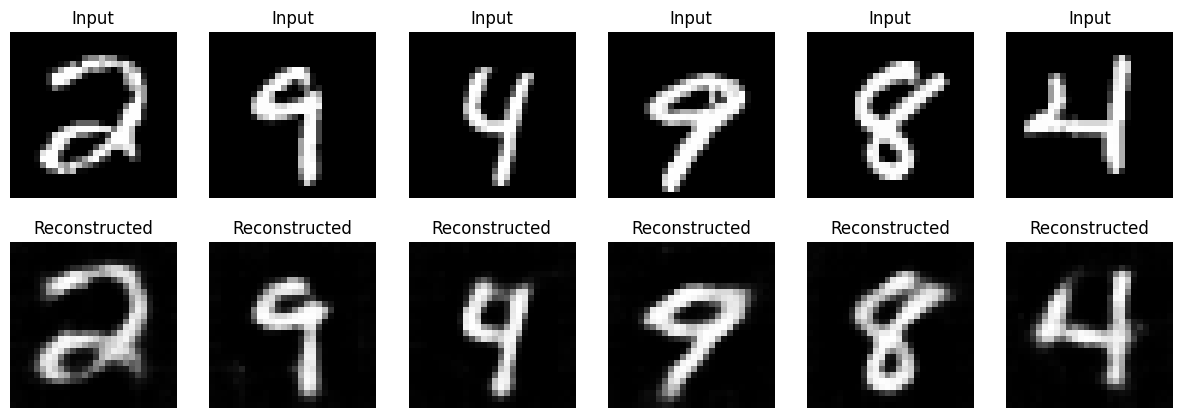

Epoch [9/10], Training Loss: 0.072448
Epoch [9/10], Validation Loss: 0.073903


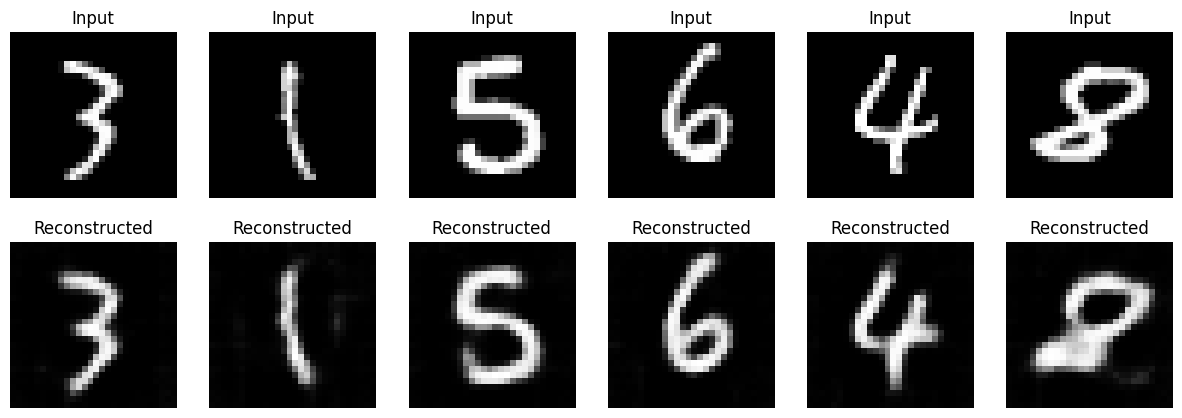

Epoch [10/10], Training Loss: 0.072476
Epoch [10/10], Validation Loss: 0.073882


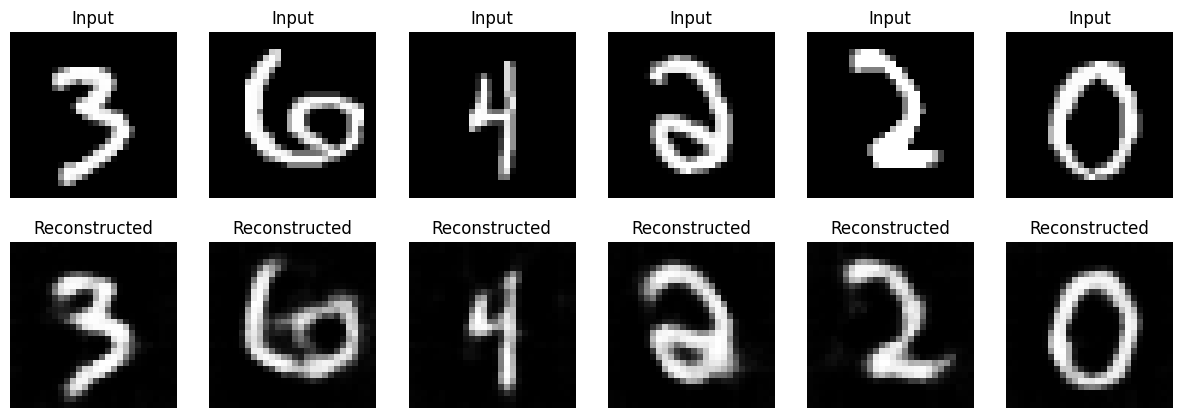

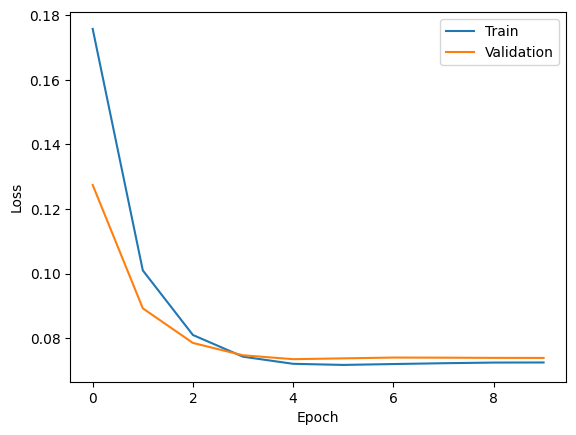

In [34]:
vq_vae = VQVAE(input_channel = 1 , channel_sizes = [64, 64], latent_dim = 64, codebook_size = 3, codebook_dim = 2 ).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=5e-4)

num_epochs = 10
lambda_co = 0.02
codebooks = []
train_losses = []
valid_losses = []
num_samples = 6


for epoch in range(num_epochs): 
    vq_vae.train()
    running_loss = 0
    for idx, (inputs, _ ) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        recon, latent_vector,quantized_vector  = vq_vae(inputs)
        loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())
        running_loss += loss.item()

    # average loss during each epoch
    epoch_loss = running_loss / idx
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.6f}')

    vq_vae.eval()

    with torch.no_grad():
        validation_loss = 0
        for idx, (inputs, _ ) in enumerate(valid_loader):
            inputs = inputs.to(device)
            recon, latent_vector, quantized_vector = vq_vae(inputs)
            loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
            validation_loss += loss.item()

    validation_epoch_loss = validation_loss / idx
    valid_losses.append(validation_epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.6f}')

    with torch.no_grad():
        inputs,_ = next(iter(test_loader))
        inputs = inputs.to(device)

        recons,_,_ = vq_vae(inputs)

        inputs = (inputs + 1) / 2
        recons = (recons + 1) / 2

        plt.figure(figsize=(5*num_samples//2, 5))
        samples = torch.randint(0, inputs.size(0), (num_samples,))
        for i, s in enumerate(samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(inputs[s][0].cpu(), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow(recons[s][0].cpu(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')

        plt.show()

# Plot Train & Validation Loss
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

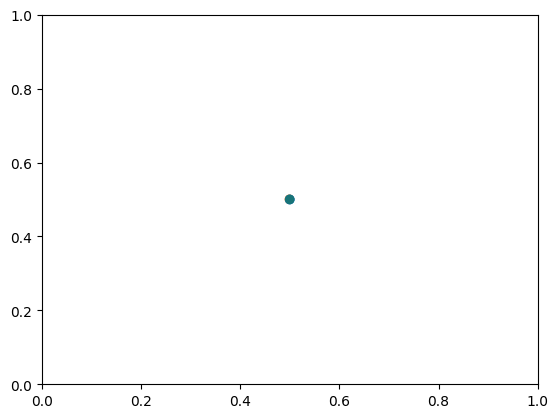

In [35]:
def generate_colors(codebook_size):
    colors1 = torch.linspace(0, 1, codebook_size)
    colors2 = colors1.flip(0)
    colors3 = torch.rand(codebook_size) / 2 + 0.5
    return torch.stack([colors1, colors2, colors3]).view(-1, 3)

def update_plot(frame, cbs, colors, ax):
    ax.clear()
    plt.scatter(cbs[frame * 10, :, 0], cbs[frame * 10, :, 1], c=1 - colors)
    plt.xlim([0, 1])
    plt.ylim([0, 1])



colors = generate_colors(codebook_size = 3)
cbs = torch.stack(codebooks)

fig, ax = plt.subplots()

ani = FuncAnimation(fig, lambda frame: update_plot(frame, cbs, colors, ax),
                    frames=cbs.shape[0] // 10, repeat=False)

ani.save('first.gif', writer='pillow', fps=30)
gif_path = 'first.gif'
html_code = f'<img src="{gif_path}" alt="animation">'
display(HTML(html_code))

codebook_size = 5
Epoch [1/10], Training Loss: 0.089965
Epoch [1/10], Validation Loss: 0.047681


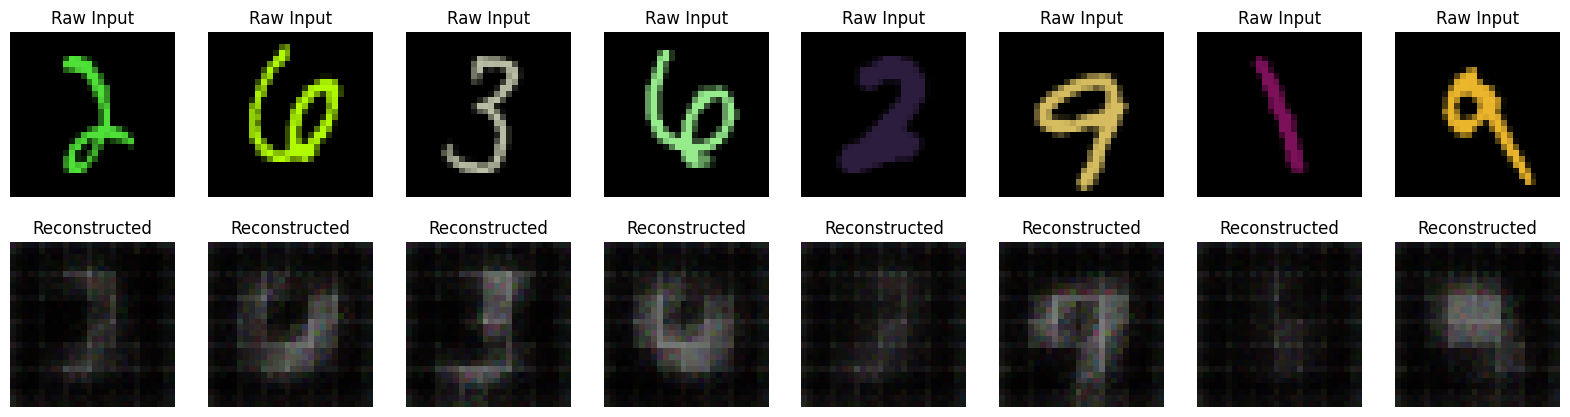

Epoch [2/10], Training Loss: 0.039273
Epoch [2/10], Validation Loss: 0.034952


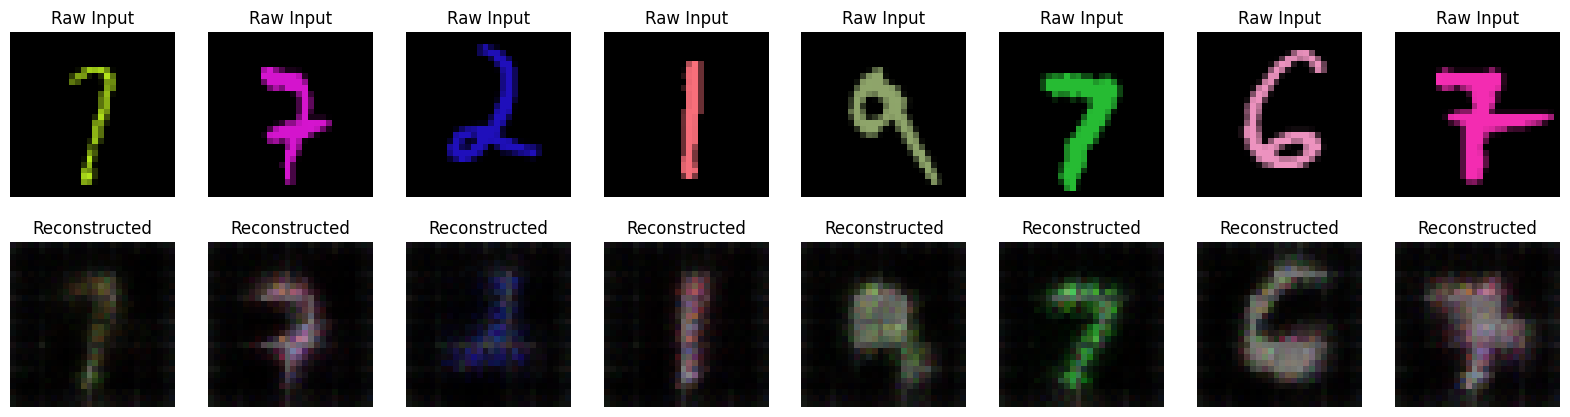

Epoch [3/10], Training Loss: 0.030981
Epoch [3/10], Validation Loss: 0.029425


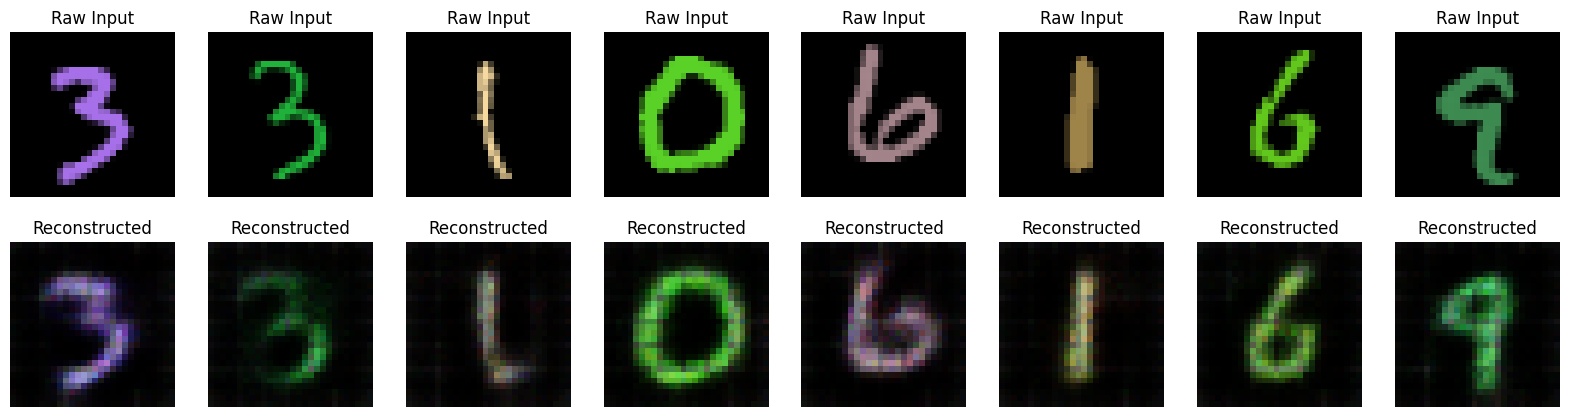

Epoch [4/10], Training Loss: 0.027080
Epoch [4/10], Validation Loss: 0.026354


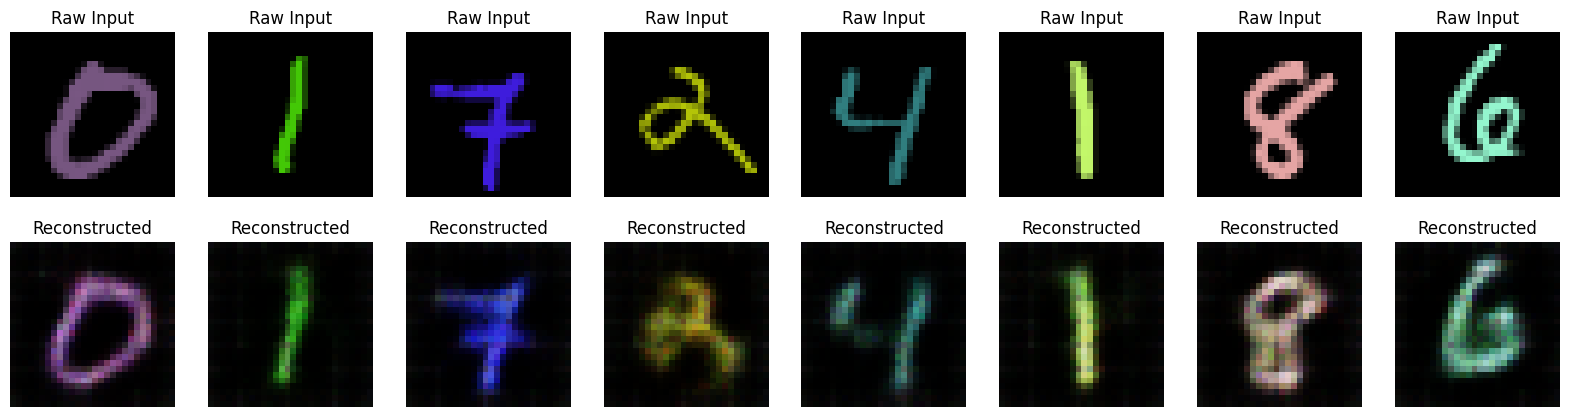

Epoch [5/10], Training Loss: 0.025268
Epoch [5/10], Validation Loss: 0.025189


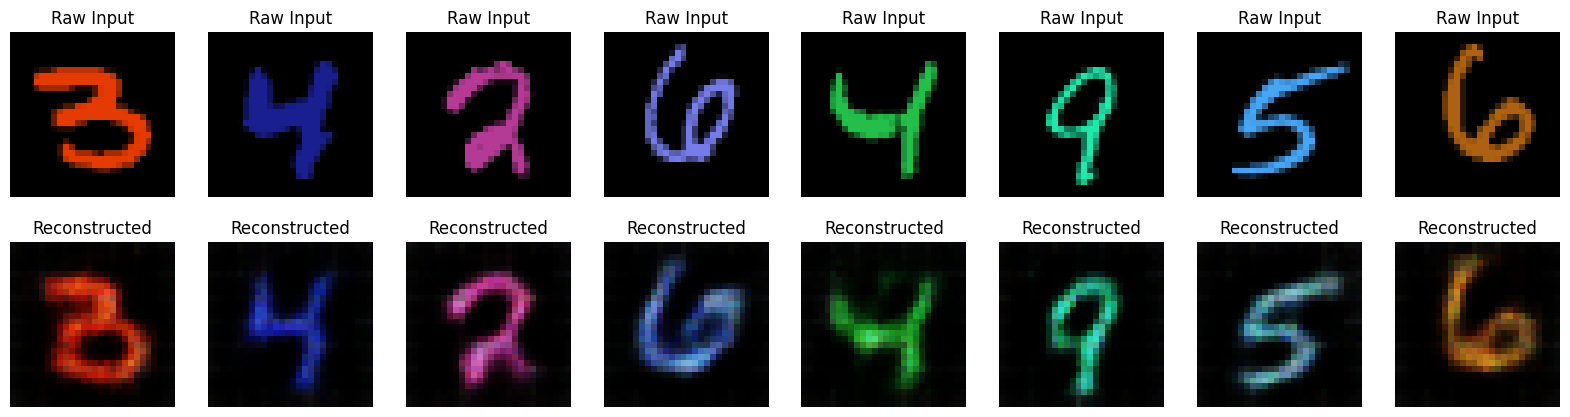

Epoch [6/10], Training Loss: 0.024500
Epoch [6/10], Validation Loss: 0.024700


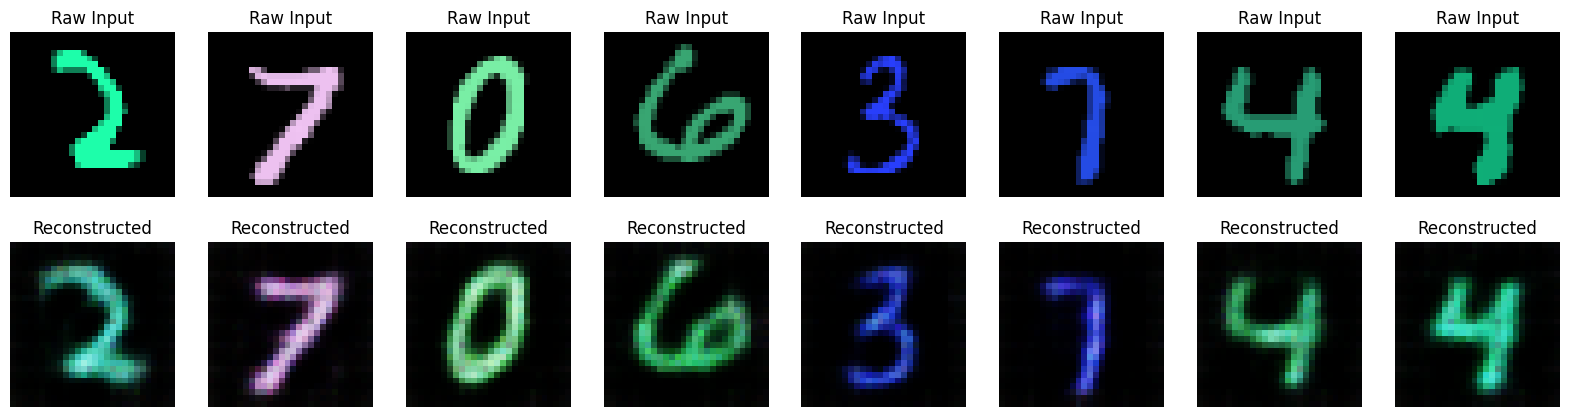

Epoch [7/10], Training Loss: 0.024103
Epoch [7/10], Validation Loss: 0.024384


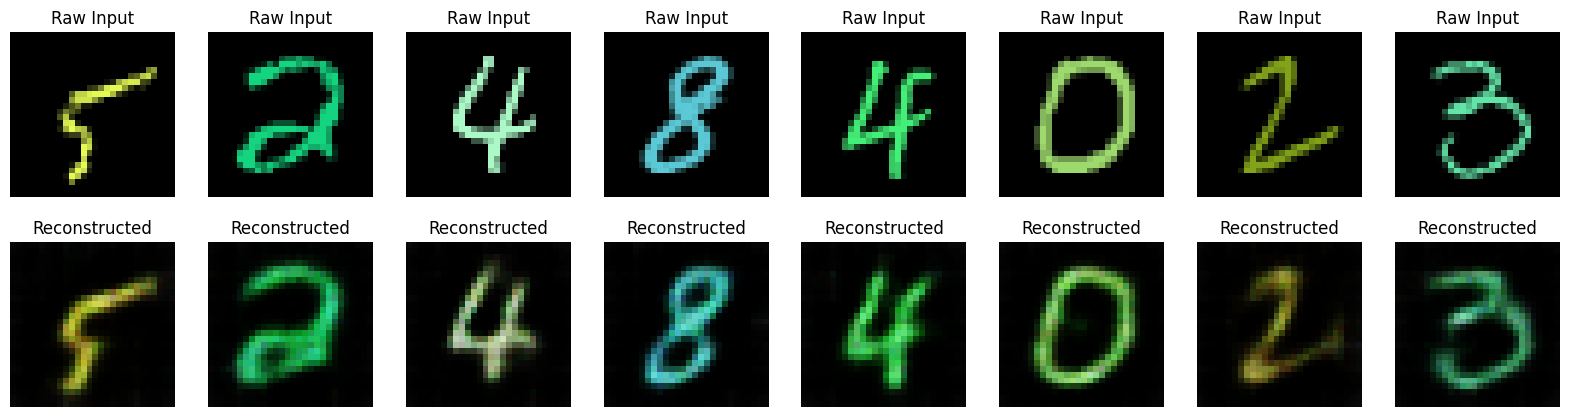

Epoch [8/10], Training Loss: 0.023782
Epoch [8/10], Validation Loss: 0.024053


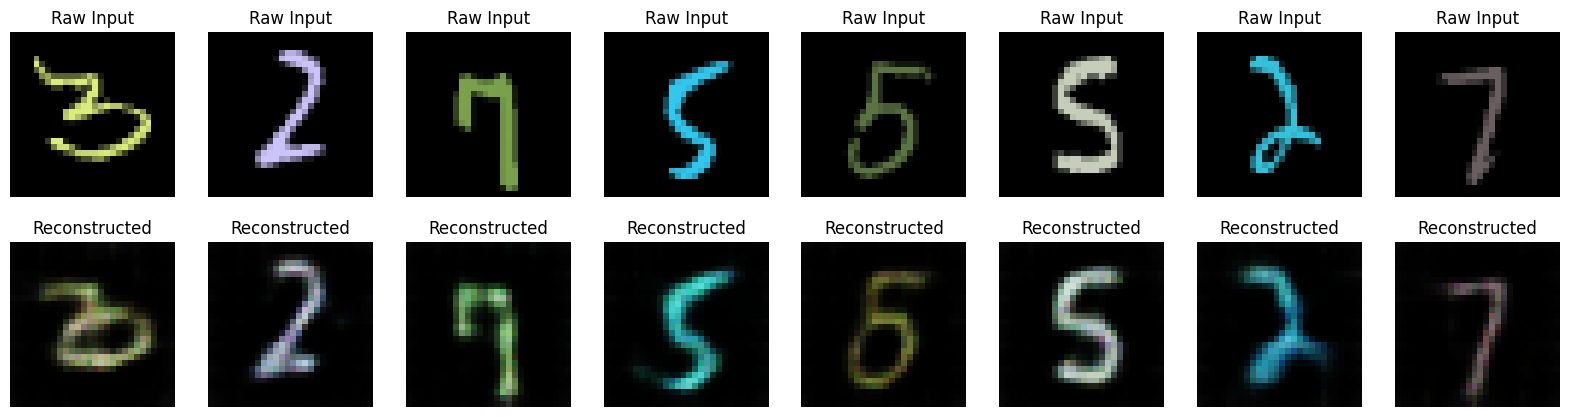

Epoch [9/10], Training Loss: 0.023609
Epoch [9/10], Validation Loss: 0.024053


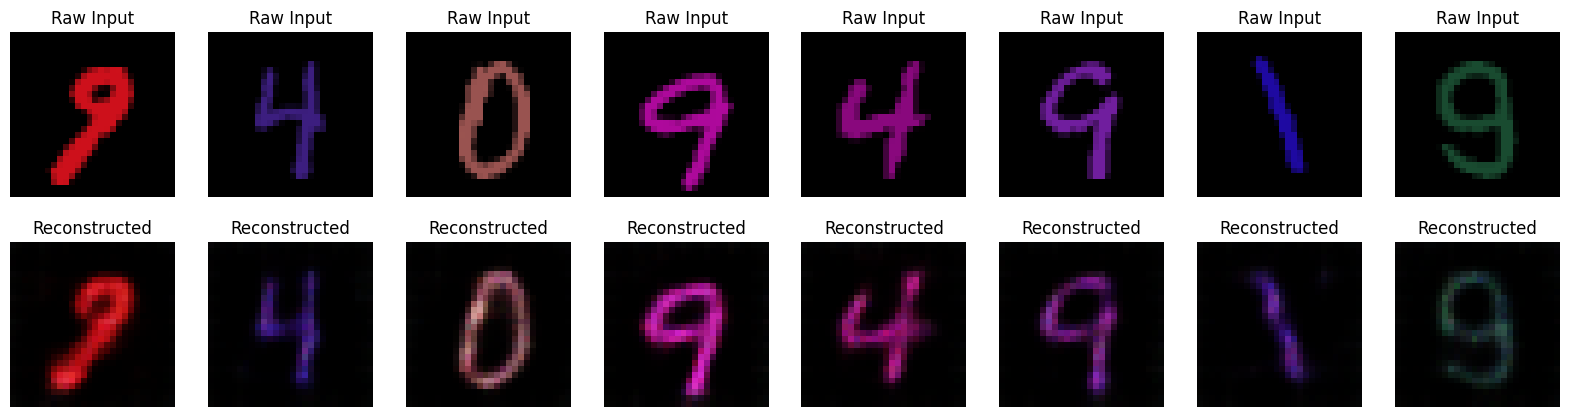

Epoch [10/10], Training Loss: 0.023453
Epoch [10/10], Validation Loss: 0.023702


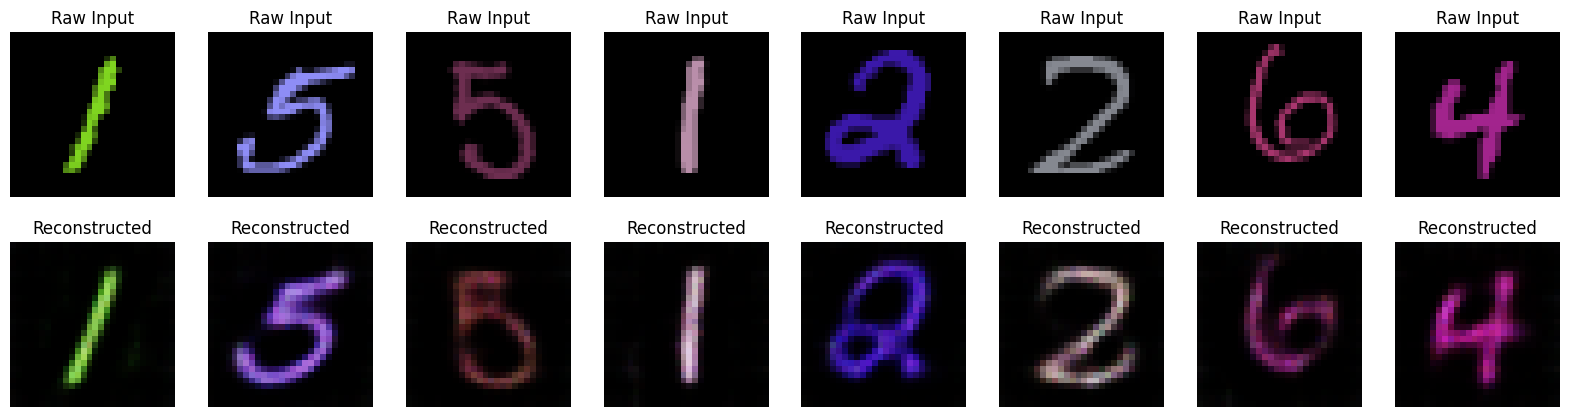

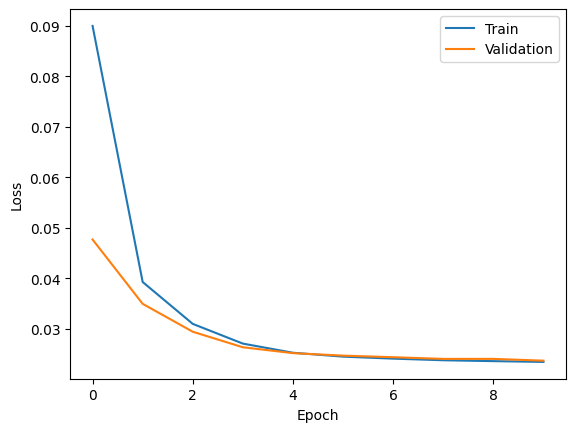

codebook_size = 15
Epoch [1/10], Training Loss: 0.083486
Epoch [1/10], Validation Loss: 0.033870


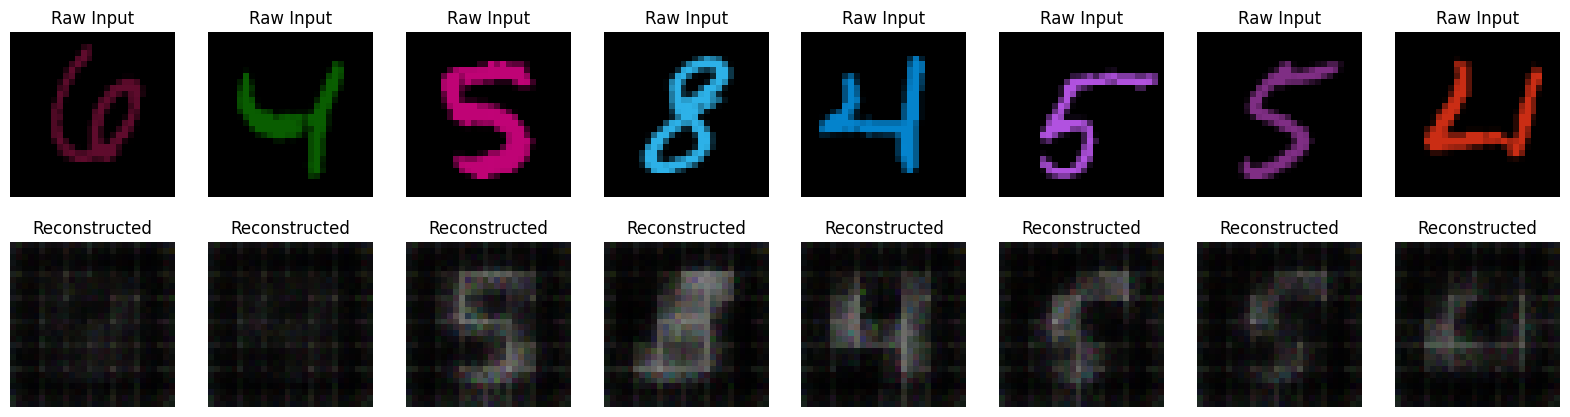

Epoch [2/10], Training Loss: 0.024902
Epoch [2/10], Validation Loss: 0.021317


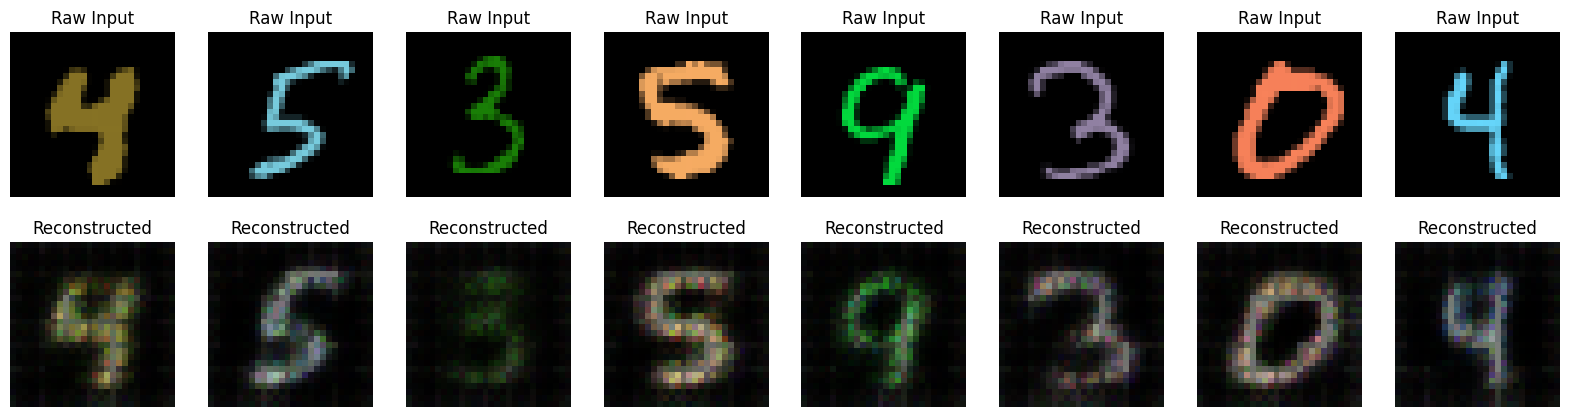

Epoch [3/10], Training Loss: 0.018089
Epoch [3/10], Validation Loss: 0.016055


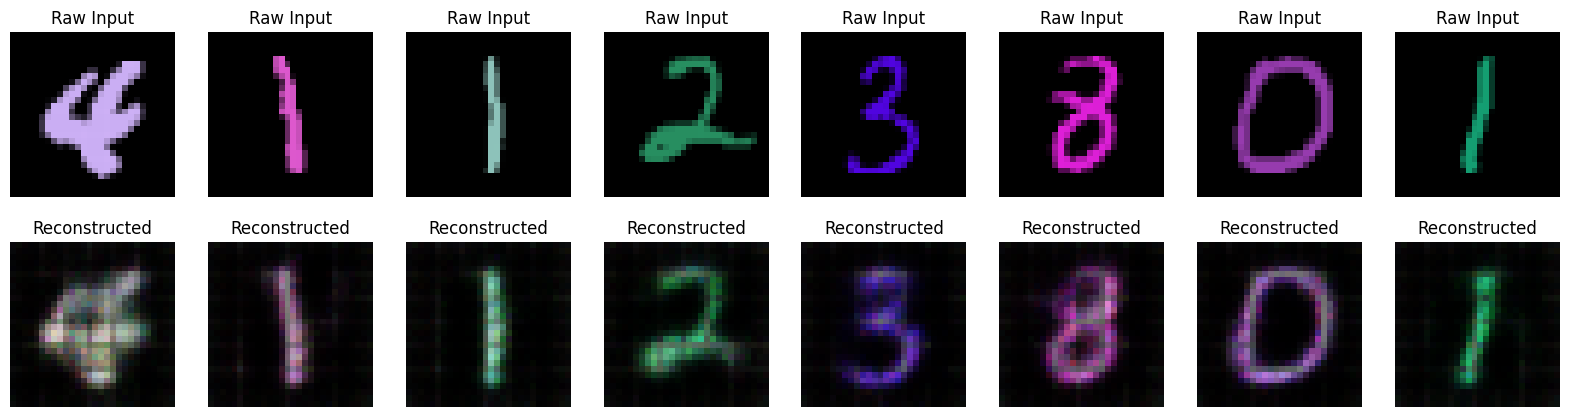

Epoch [4/10], Training Loss: 0.013928
Epoch [4/10], Validation Loss: 0.012596


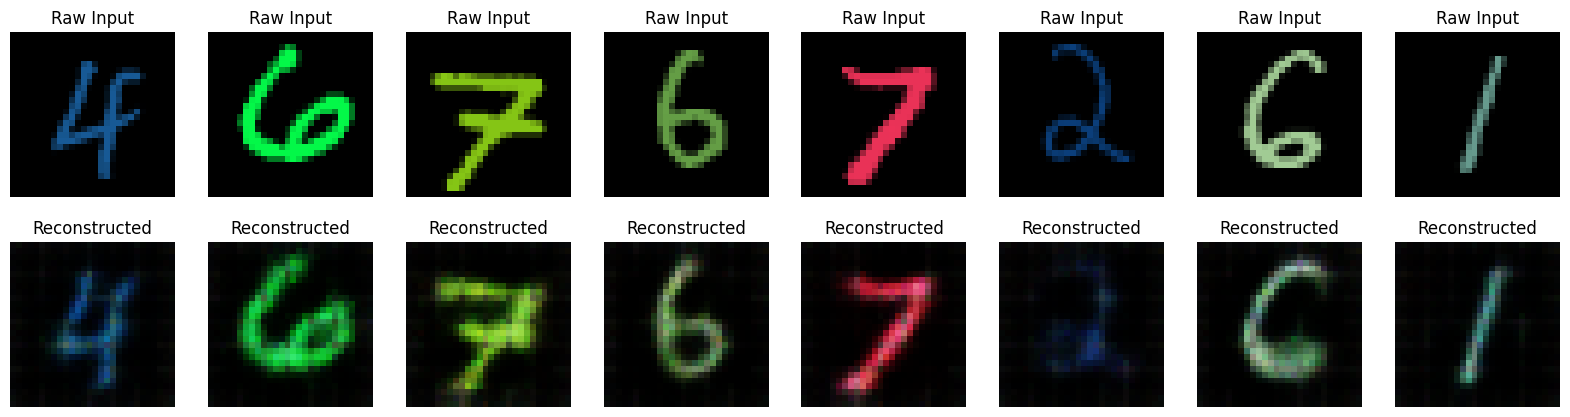

Epoch [5/10], Training Loss: 0.011674
Epoch [5/10], Validation Loss: 0.011200


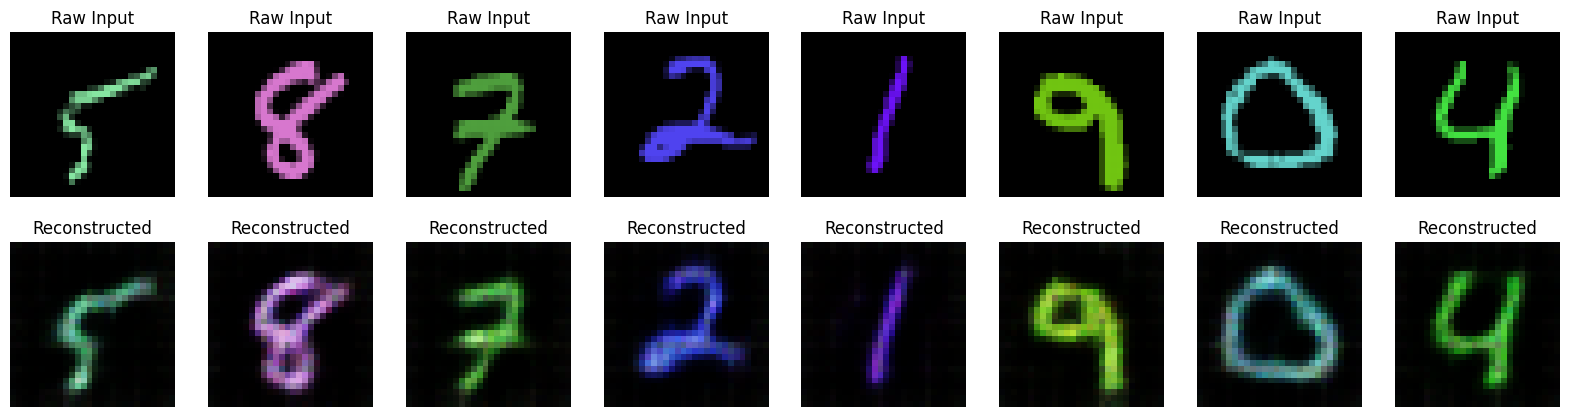

Epoch [6/10], Training Loss: 0.010454
Epoch [6/10], Validation Loss: 0.010156


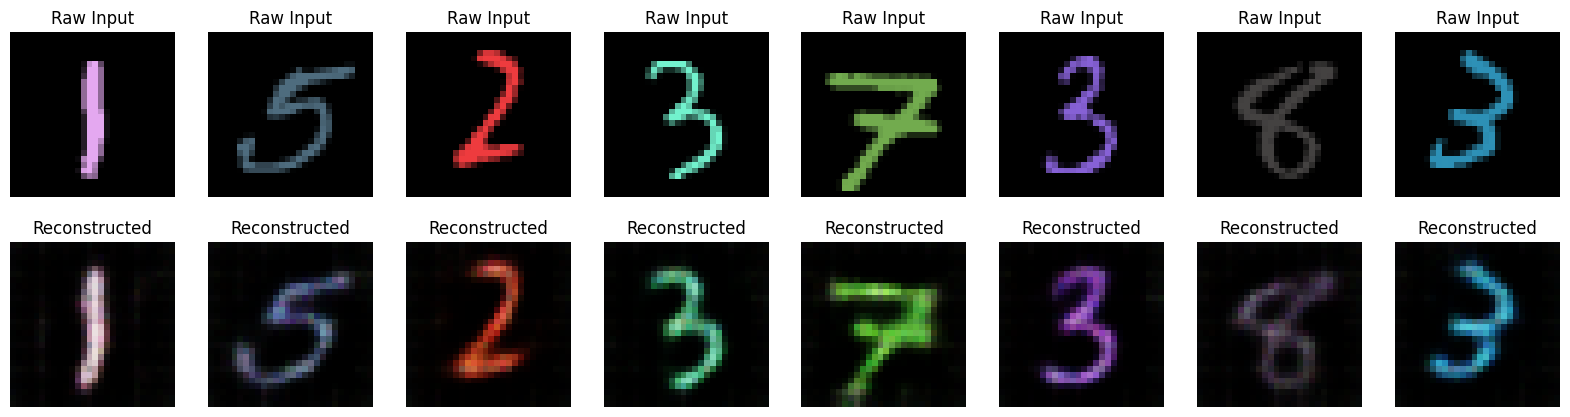

Epoch [7/10], Training Loss: 0.009773
Epoch [7/10], Validation Loss: 0.009769


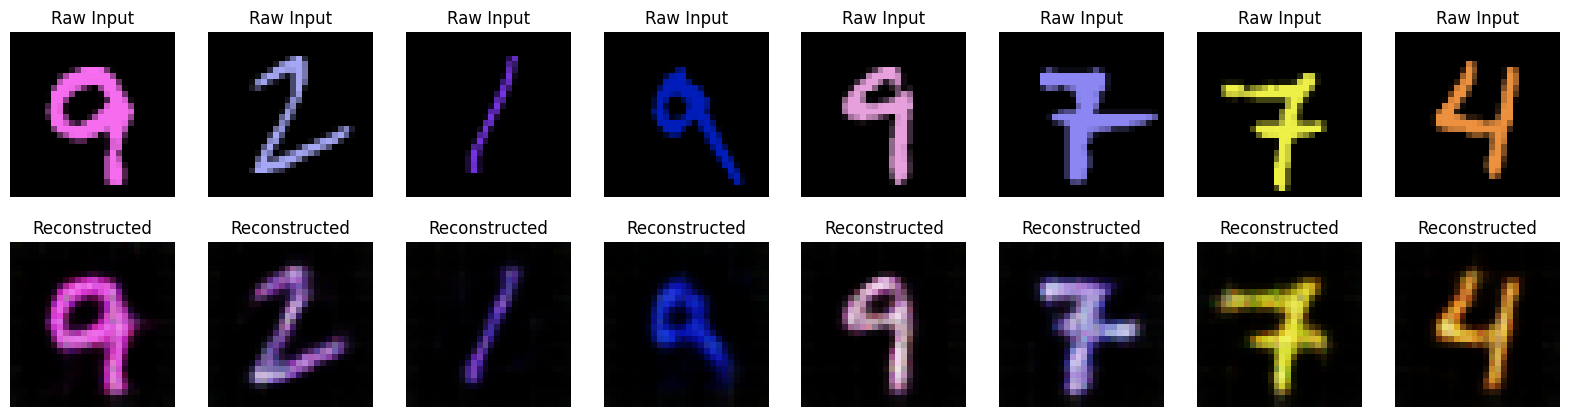

Epoch [8/10], Training Loss: 0.009336
Epoch [8/10], Validation Loss: 0.009333


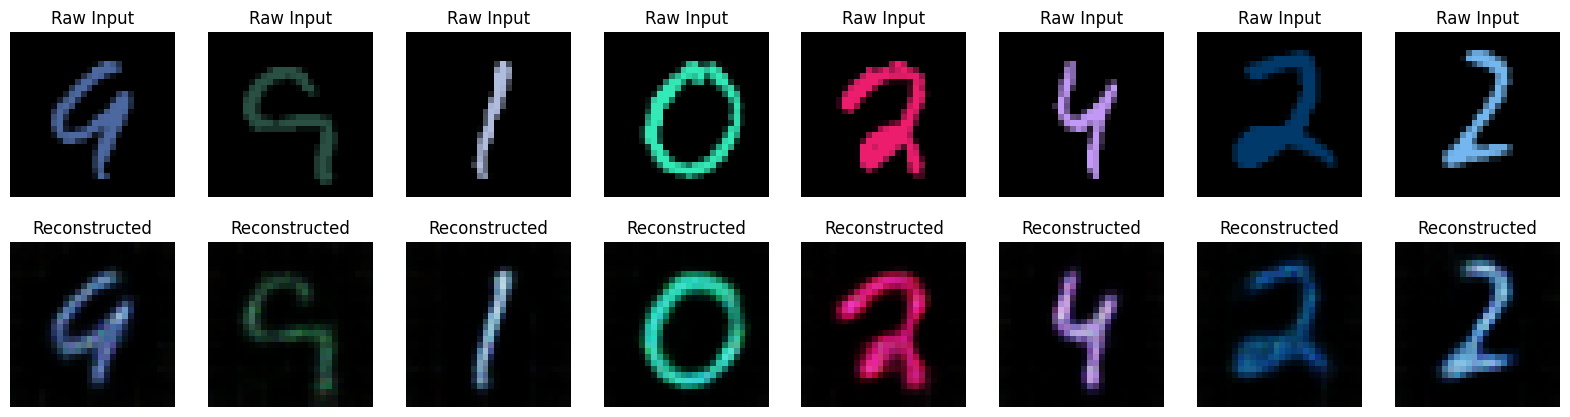

Epoch [9/10], Training Loss: 0.009029
Epoch [9/10], Validation Loss: 0.008958


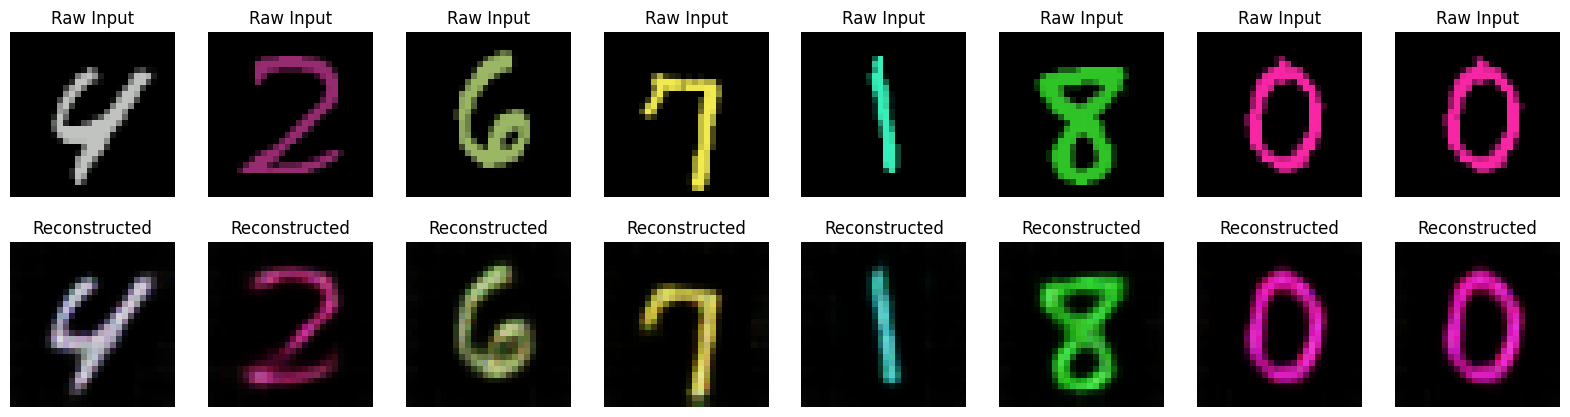

Epoch [10/10], Training Loss: 0.008737
Epoch [10/10], Validation Loss: 0.009328


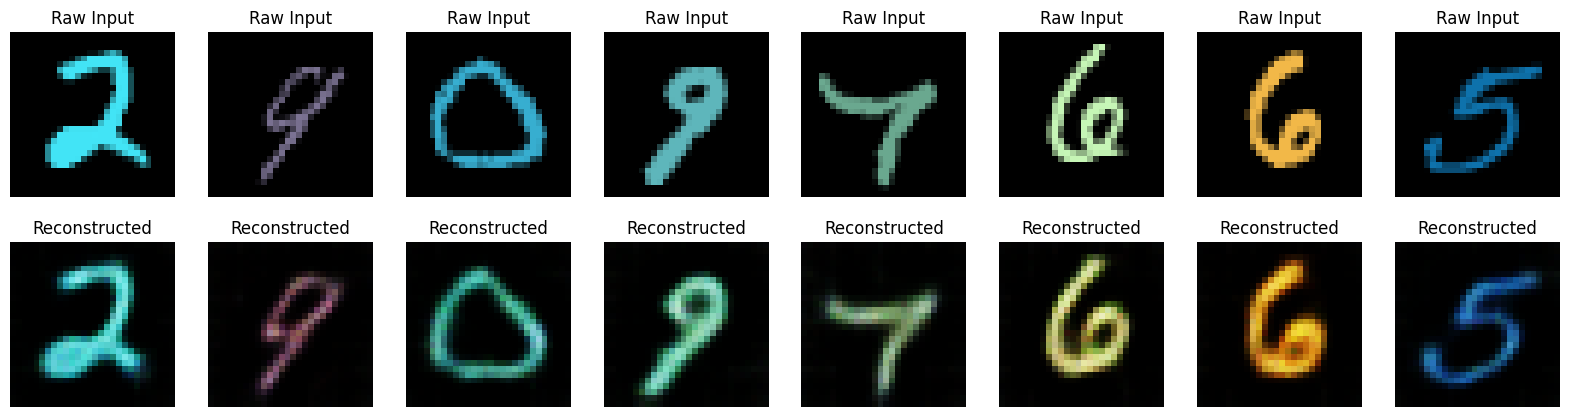

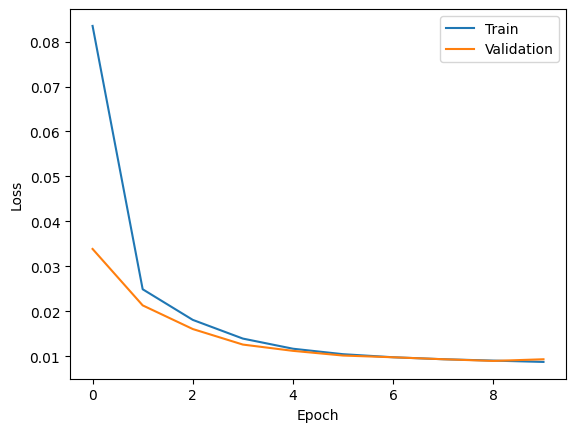

codebook_size = 25
Epoch [1/10], Training Loss: 0.082079
Epoch [1/10], Validation Loss: 0.030155


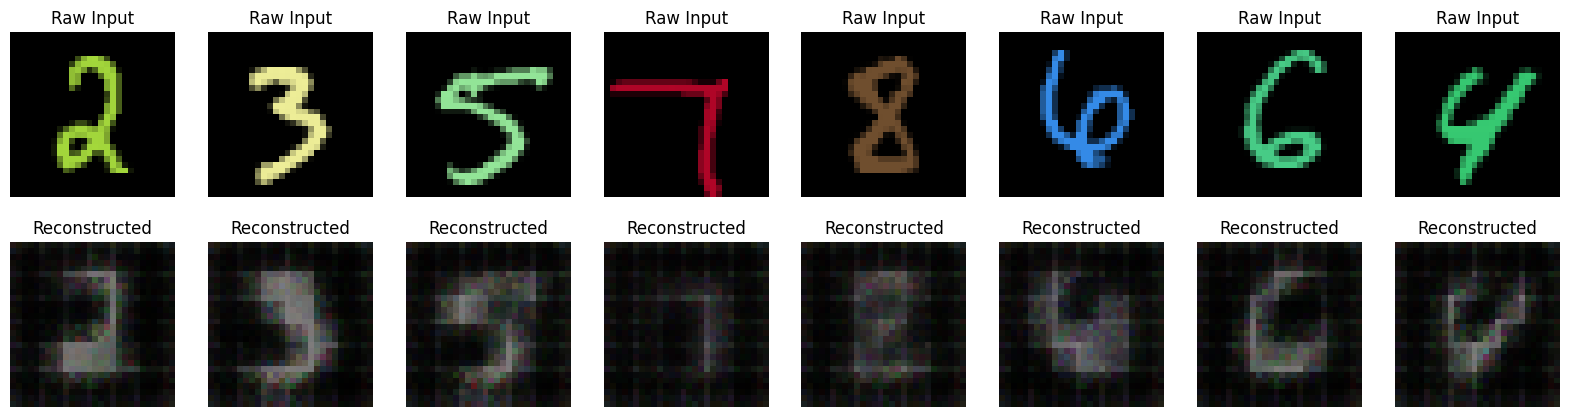

Epoch [2/10], Training Loss: 0.020436
Epoch [2/10], Validation Loss: 0.016082


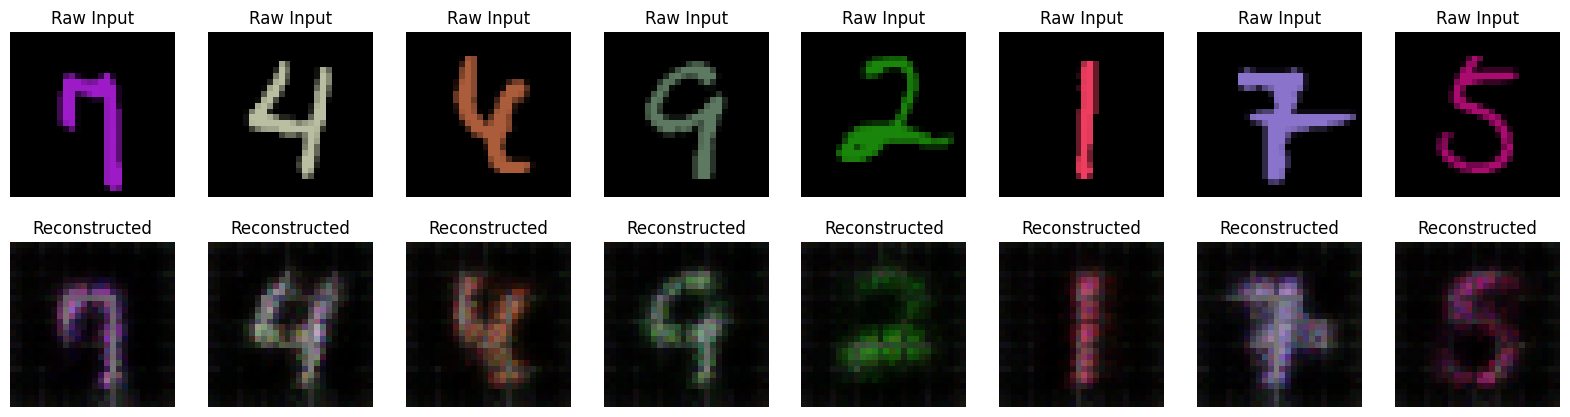

Epoch [3/10], Training Loss: 0.013180
Epoch [3/10], Validation Loss: 0.011441


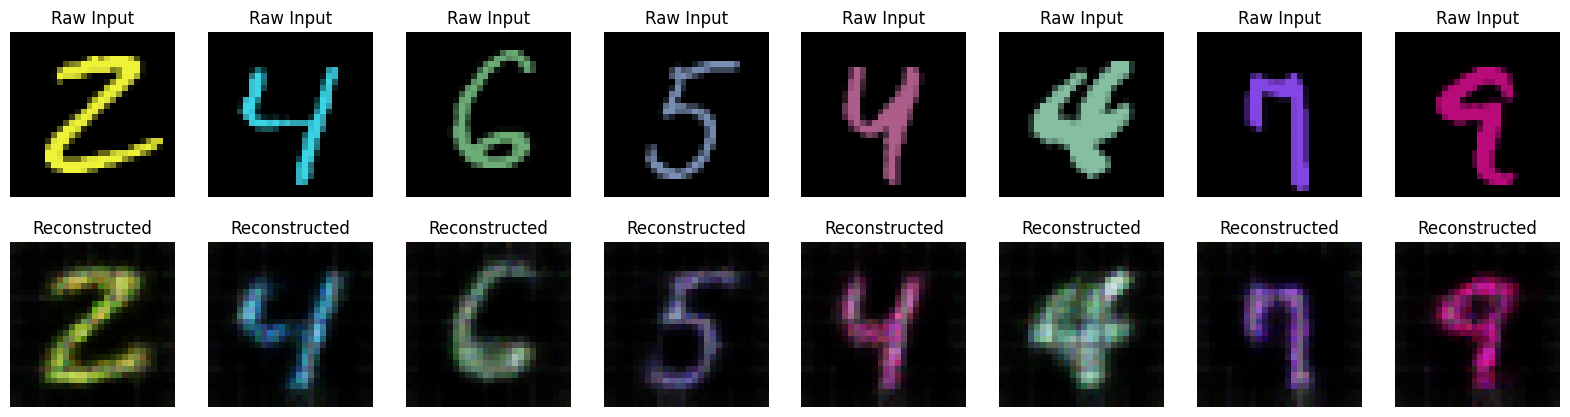

Epoch [4/10], Training Loss: 0.009997
Epoch [4/10], Validation Loss: 0.009255


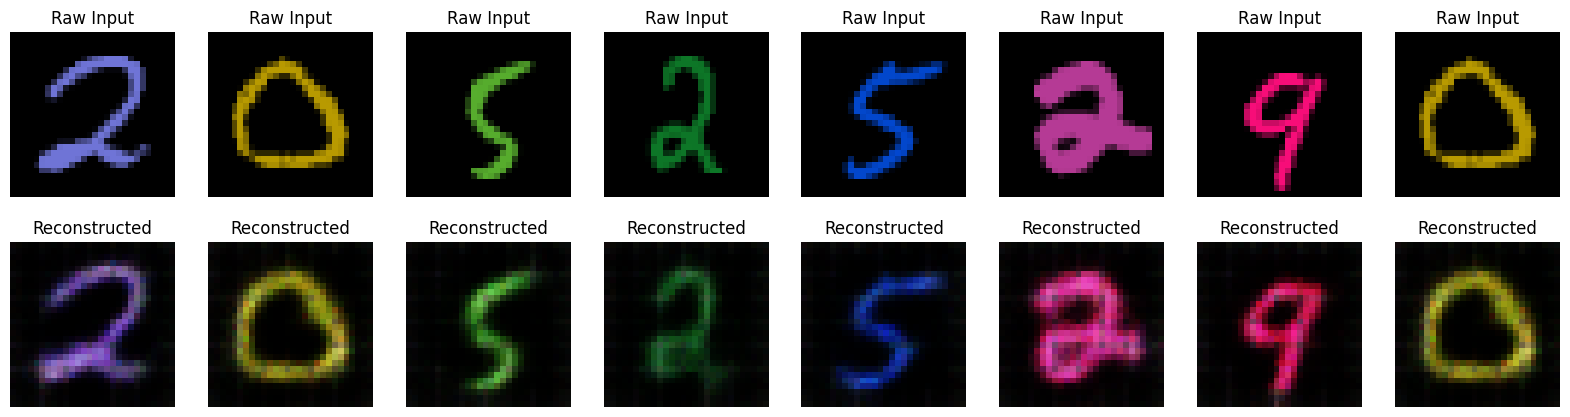

Epoch [5/10], Training Loss: 0.008501
Epoch [5/10], Validation Loss: 0.008054


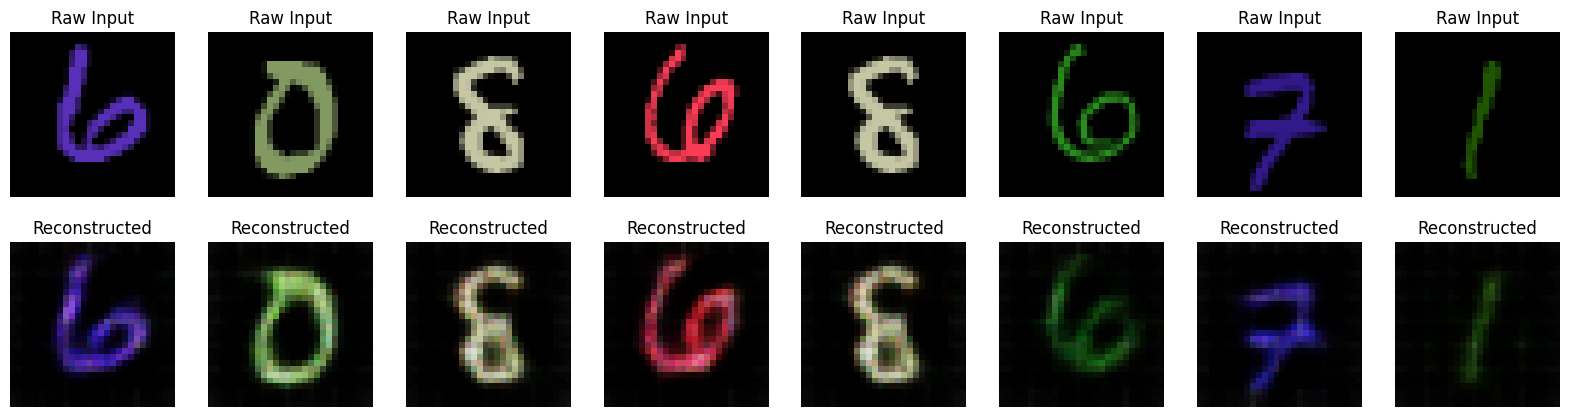

Epoch [6/10], Training Loss: 0.007616
Epoch [6/10], Validation Loss: 0.007545


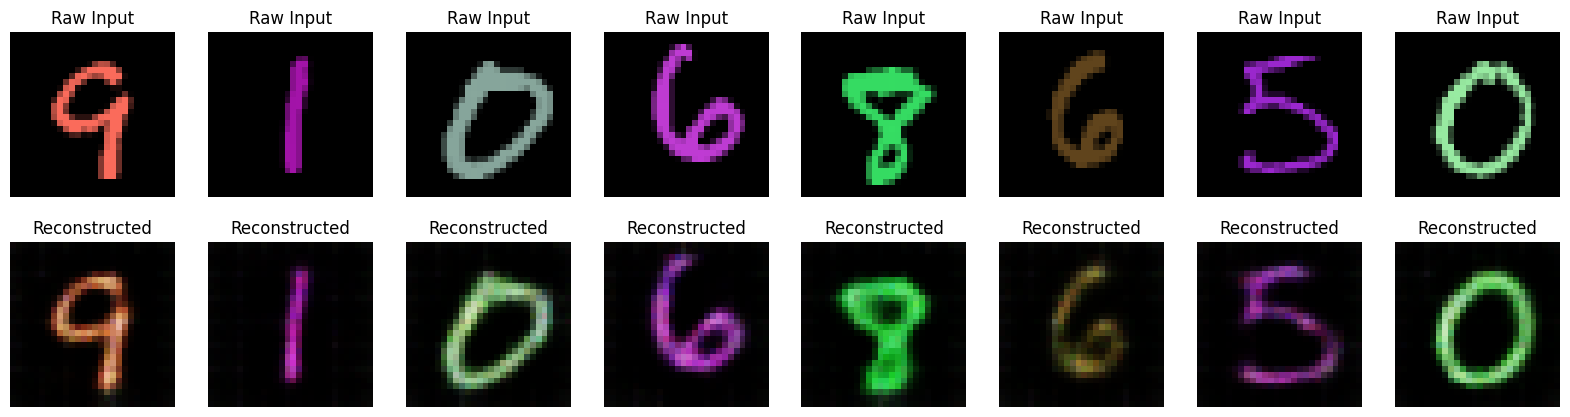

Epoch [7/10], Training Loss: 0.007048
Epoch [7/10], Validation Loss: 0.006982


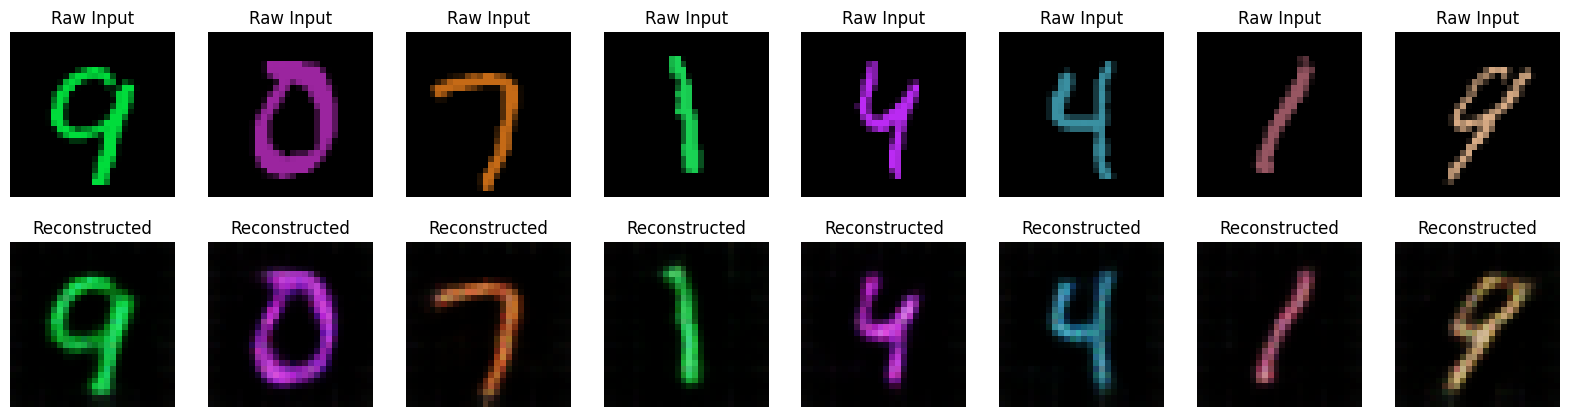

Epoch [8/10], Training Loss: 0.006672
Epoch [8/10], Validation Loss: 0.006735


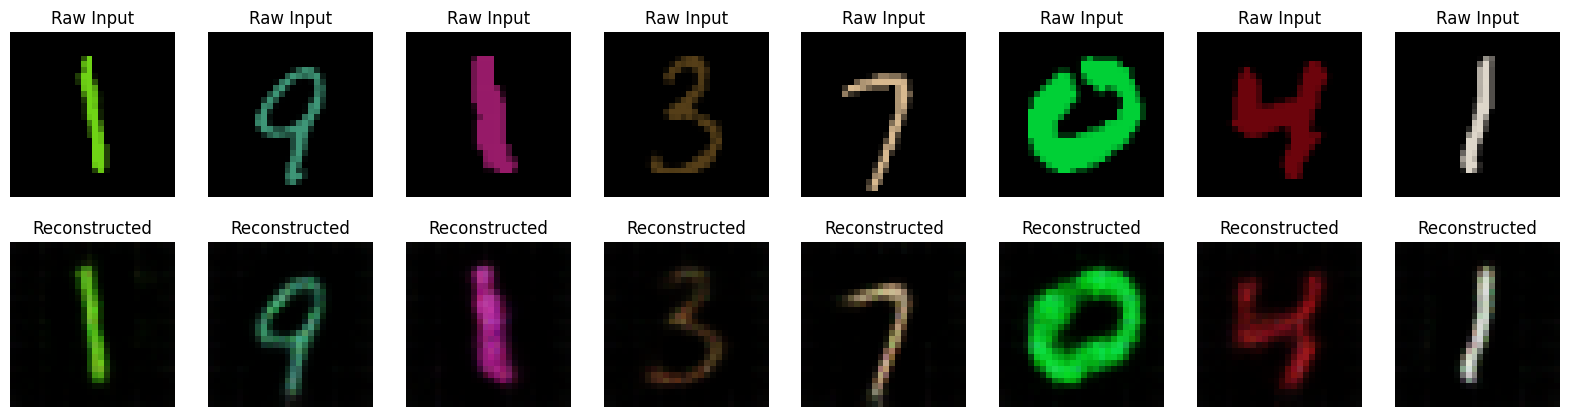

Epoch [9/10], Training Loss: 0.006421
Epoch [9/10], Validation Loss: 0.006383


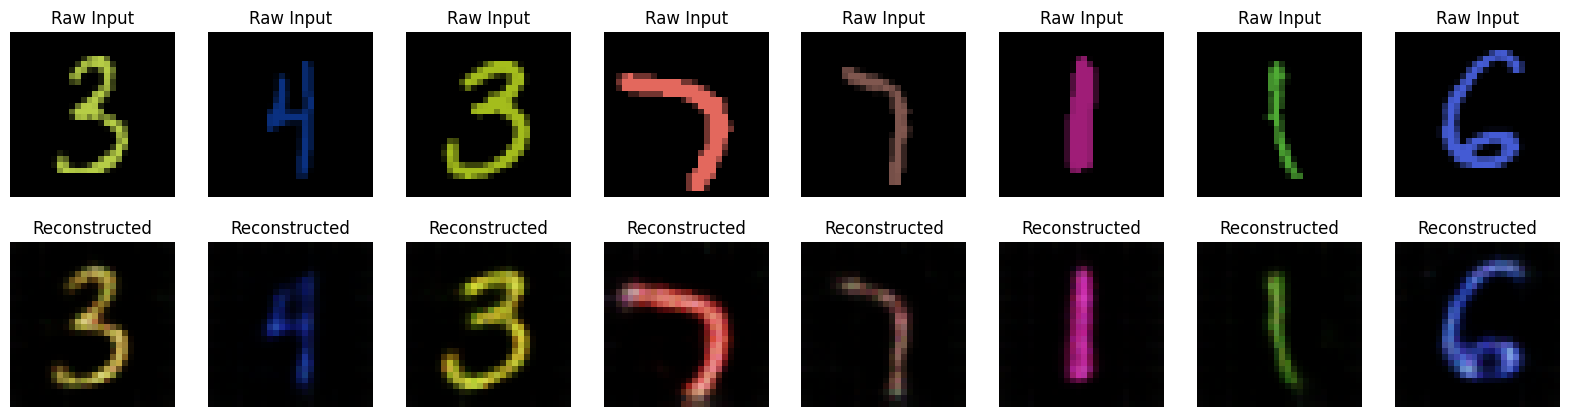

Epoch [10/10], Training Loss: 0.006196
Epoch [10/10], Validation Loss: 0.006200


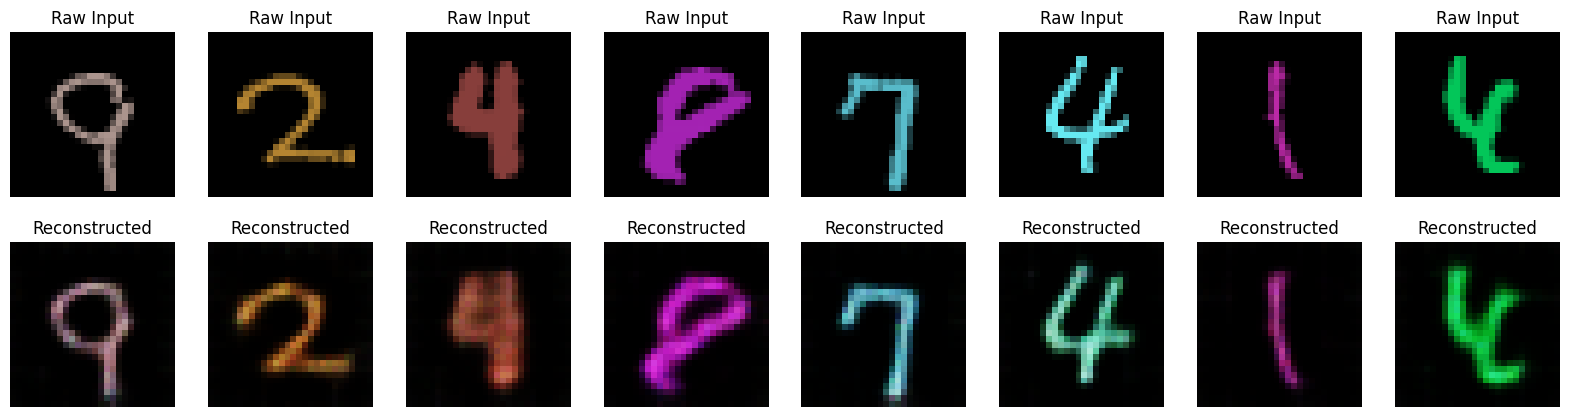

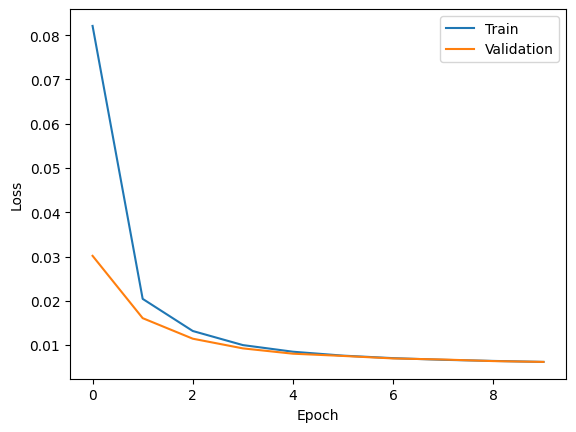

codebook_size = 35
Epoch [1/10], Training Loss: 0.086991
Epoch [1/10], Validation Loss: 0.029892


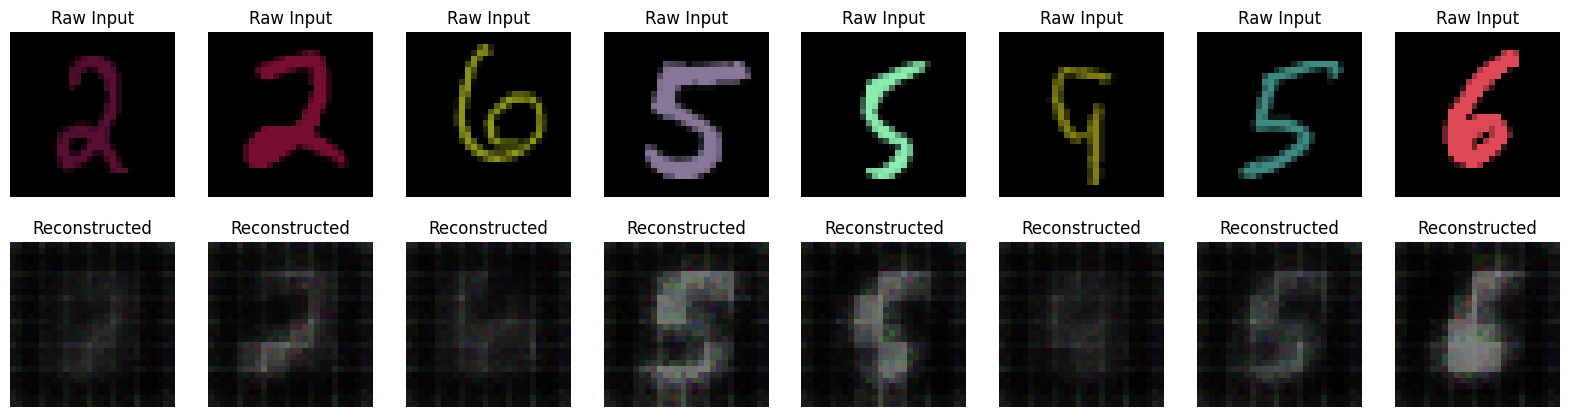

Epoch [2/10], Training Loss: 0.019457
Epoch [2/10], Validation Loss: 0.015172


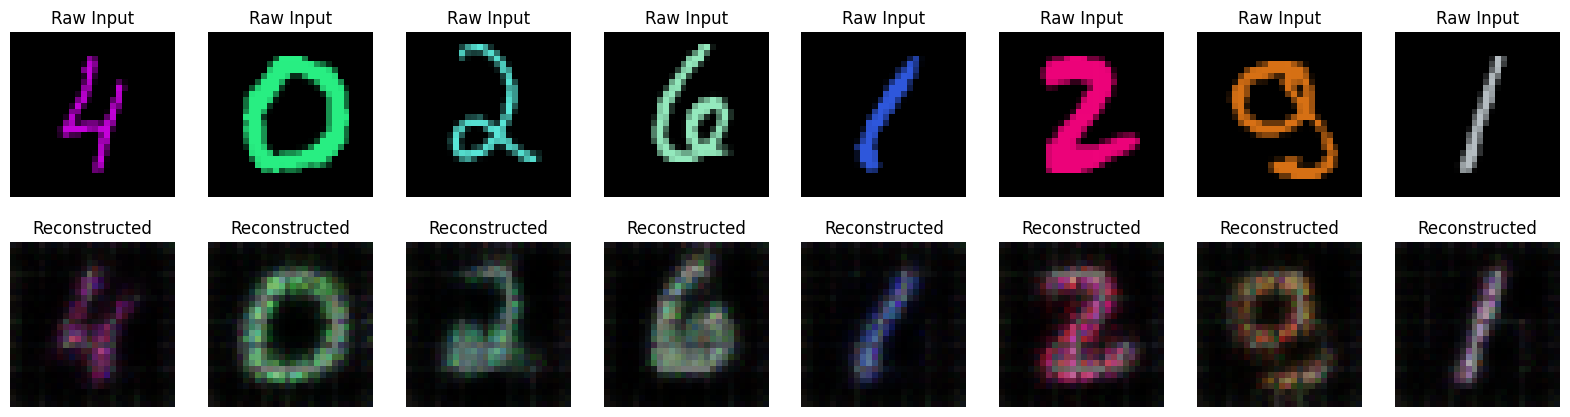

Epoch [3/10], Training Loss: 0.012204
Epoch [3/10], Validation Loss: 0.010302


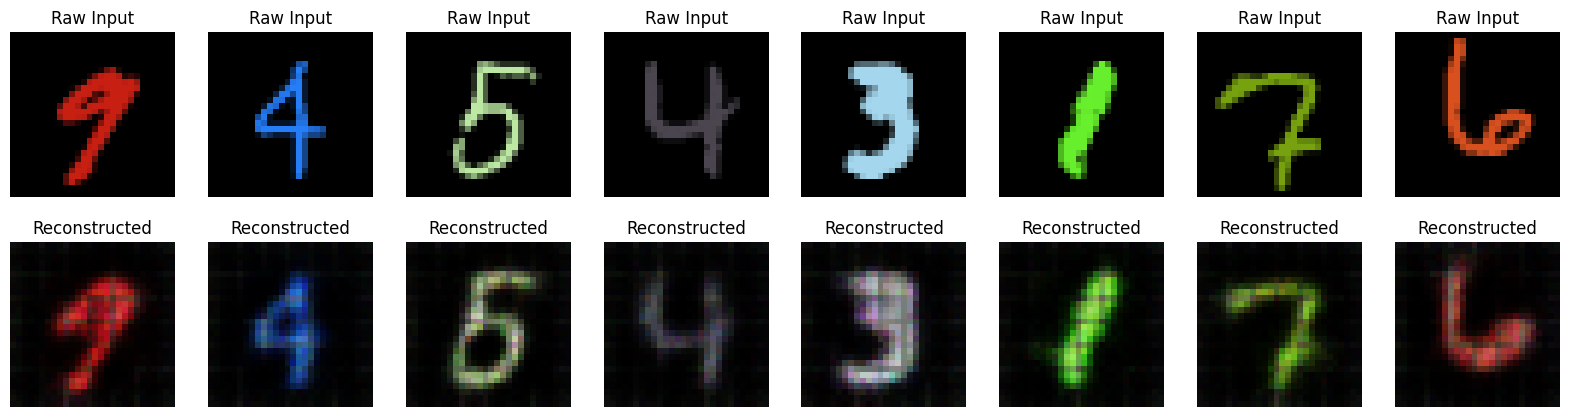

Epoch [4/10], Training Loss: 0.008946
Epoch [4/10], Validation Loss: 0.008326


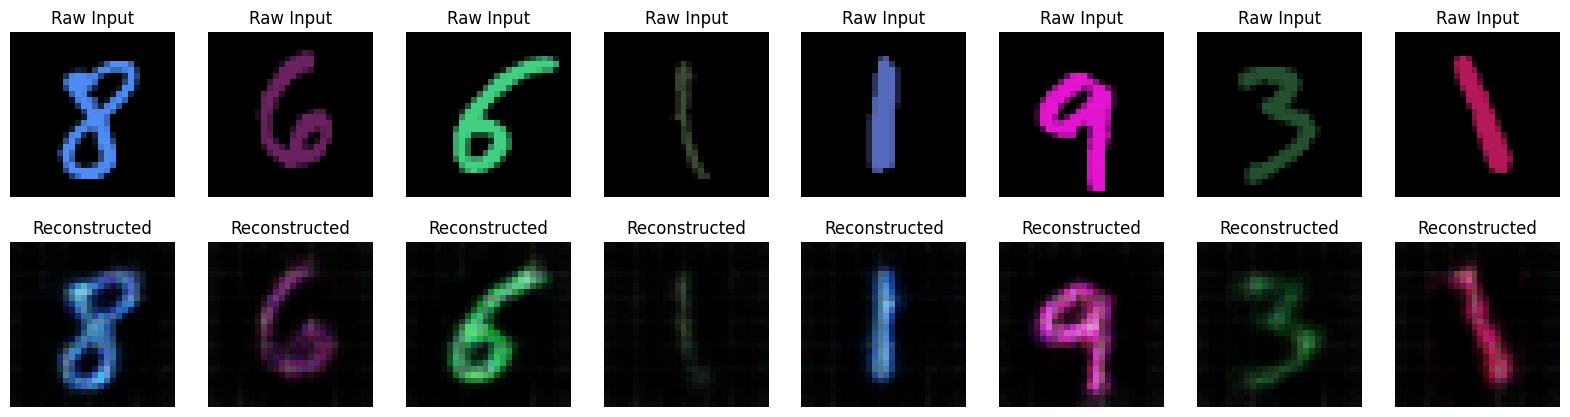

Epoch [5/10], Training Loss: 0.007387
Epoch [5/10], Validation Loss: 0.007260


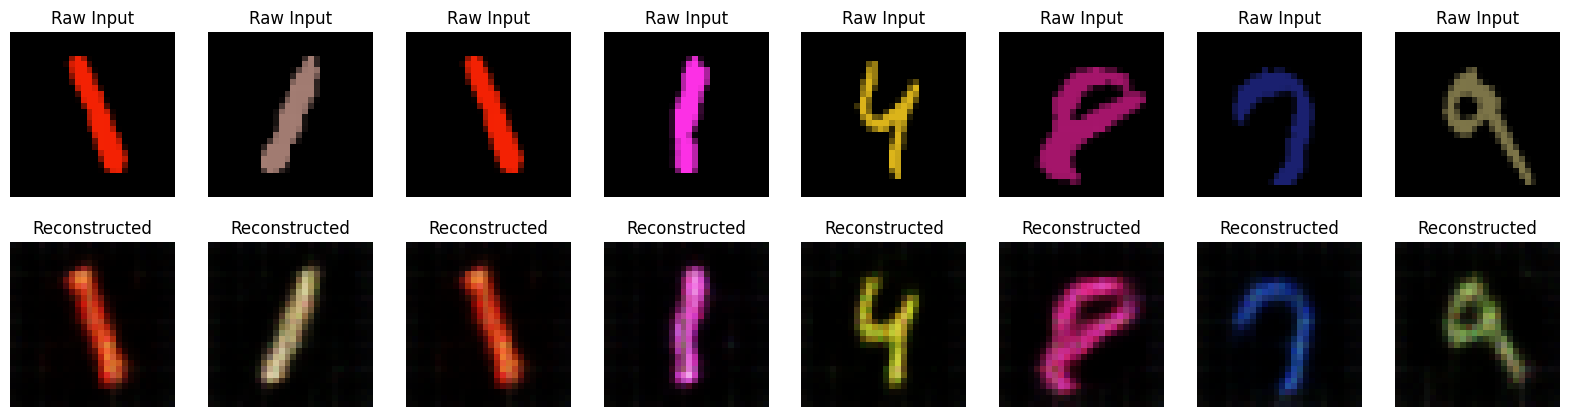

Epoch [6/10], Training Loss: 0.006487
Epoch [6/10], Validation Loss: 0.006263


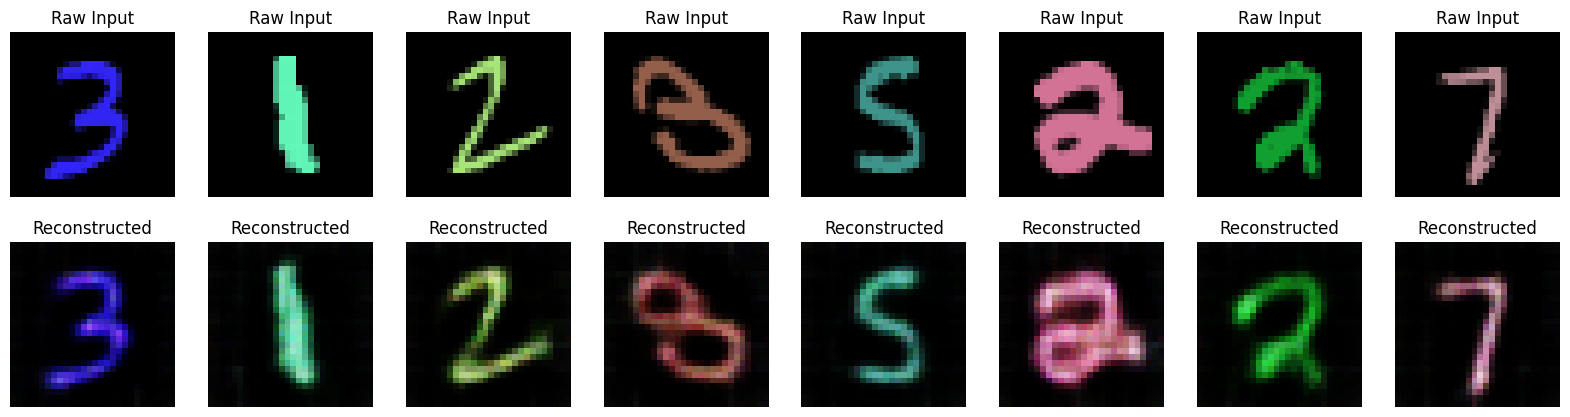

Epoch [7/10], Training Loss: 0.005956
Epoch [7/10], Validation Loss: 0.005825


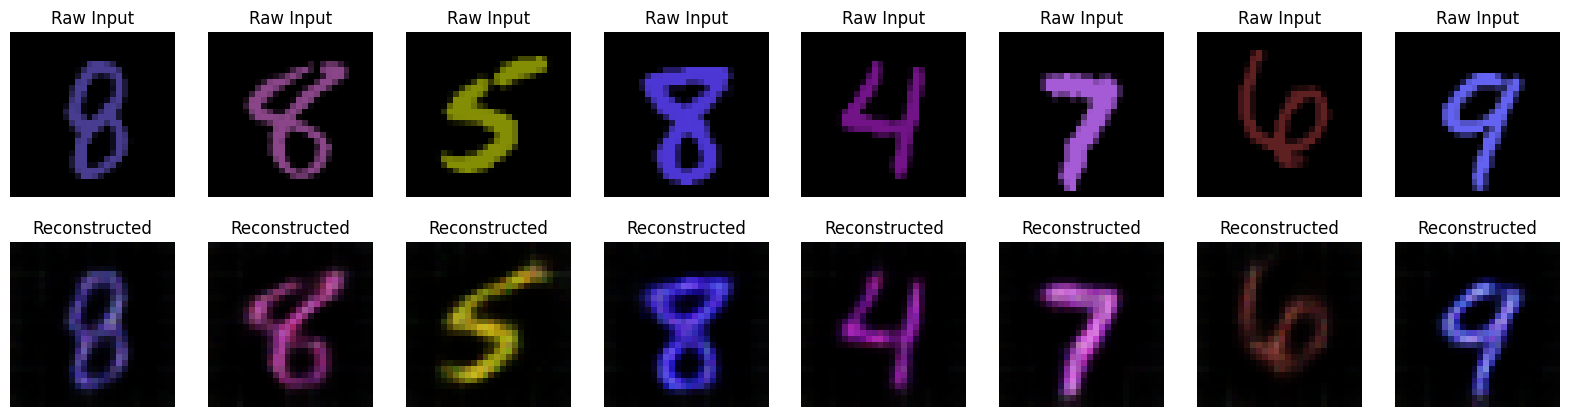

Epoch [8/10], Training Loss: 0.005550
Epoch [8/10], Validation Loss: 0.005543


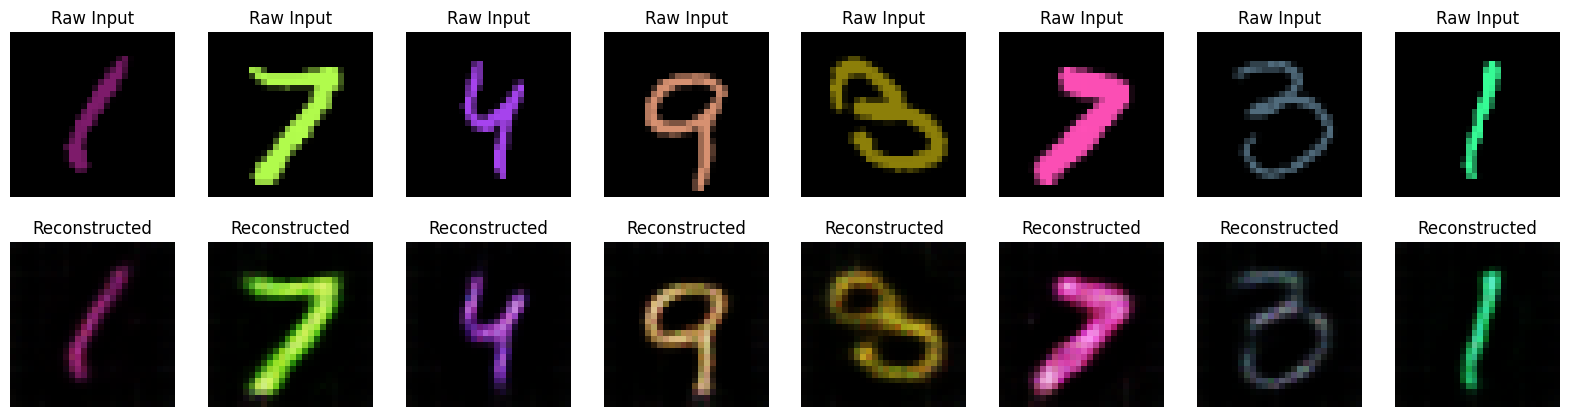

Epoch [9/10], Training Loss: 0.005297
Epoch [9/10], Validation Loss: 0.005340


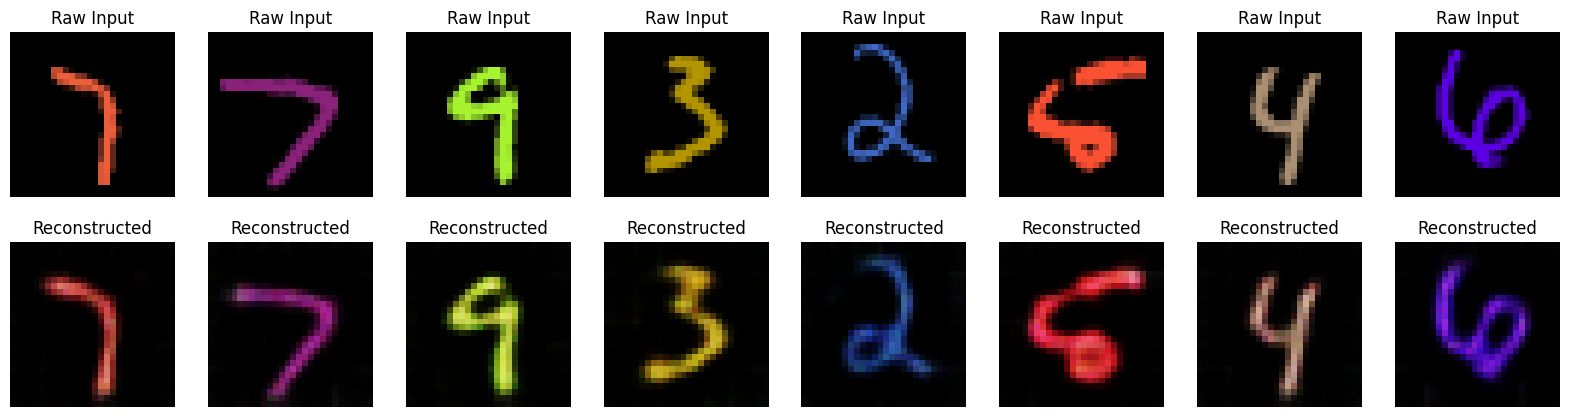

Epoch [10/10], Training Loss: 0.005117
Epoch [10/10], Validation Loss: 0.005123


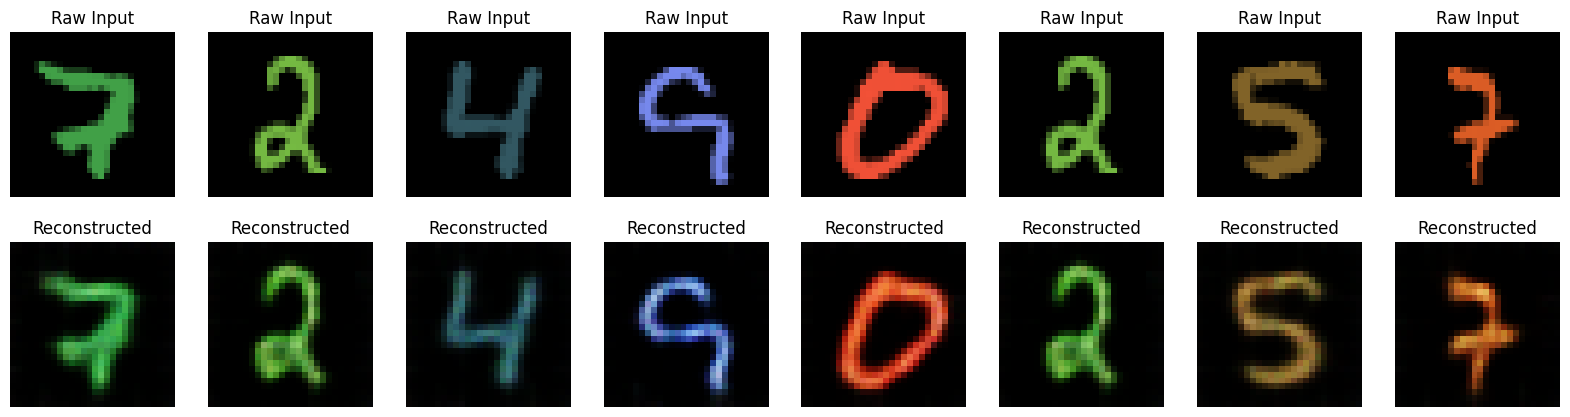

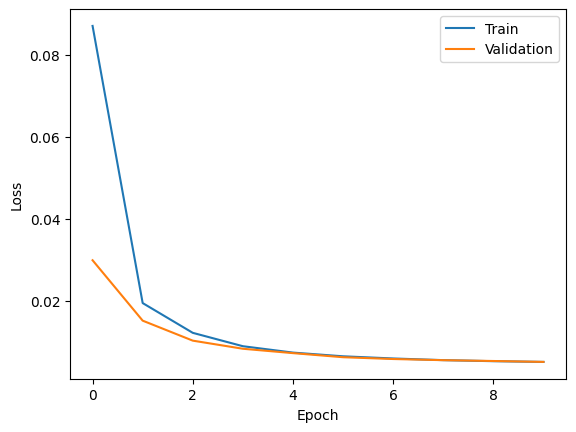

codebook_size = 45
Epoch [1/10], Training Loss: 0.084643
Epoch [1/10], Validation Loss: 0.029711


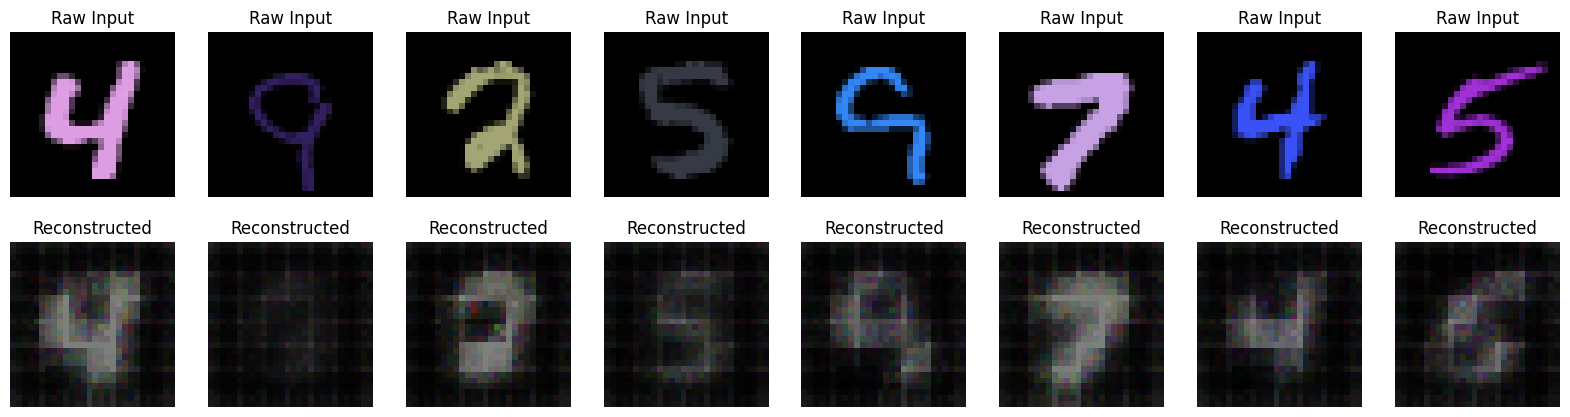

Epoch [2/10], Training Loss: 0.019624
Epoch [2/10], Validation Loss: 0.015344


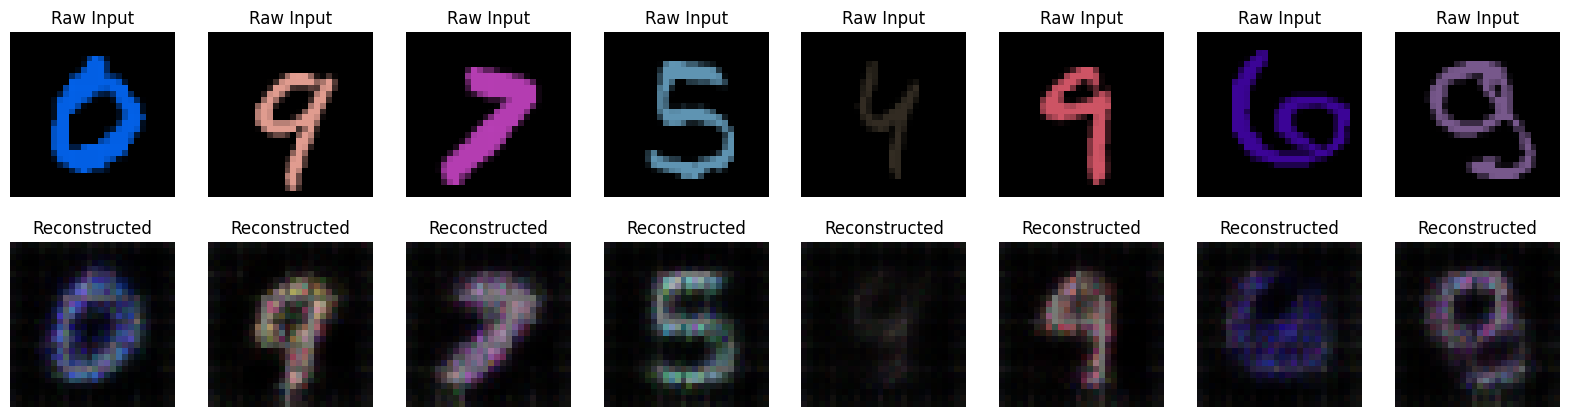

Epoch [3/10], Training Loss: 0.012282
Epoch [3/10], Validation Loss: 0.010228


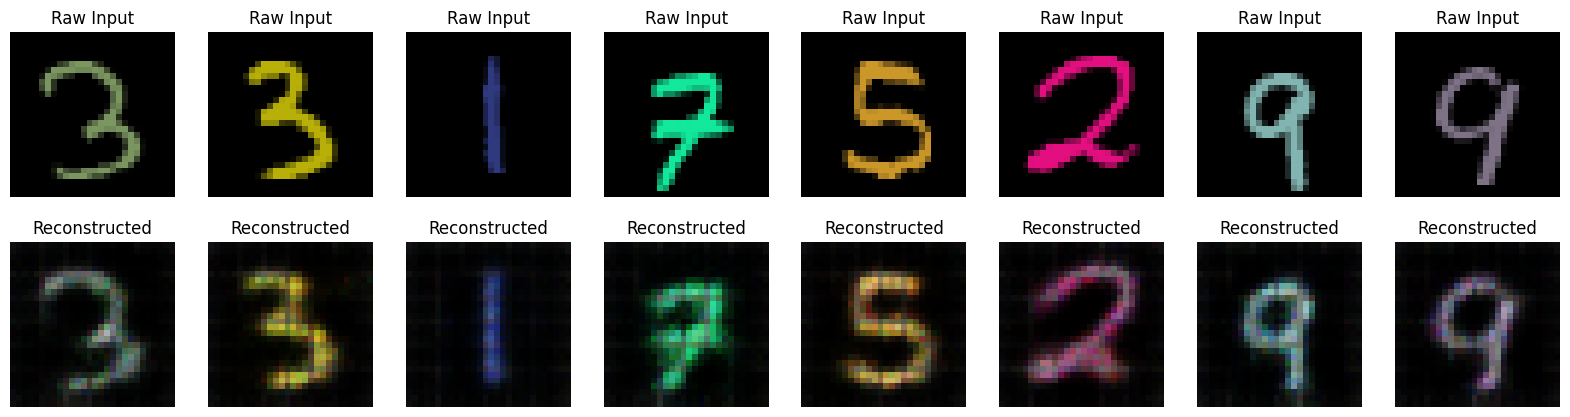

Epoch [4/10], Training Loss: 0.008768
Epoch [4/10], Validation Loss: 0.008017


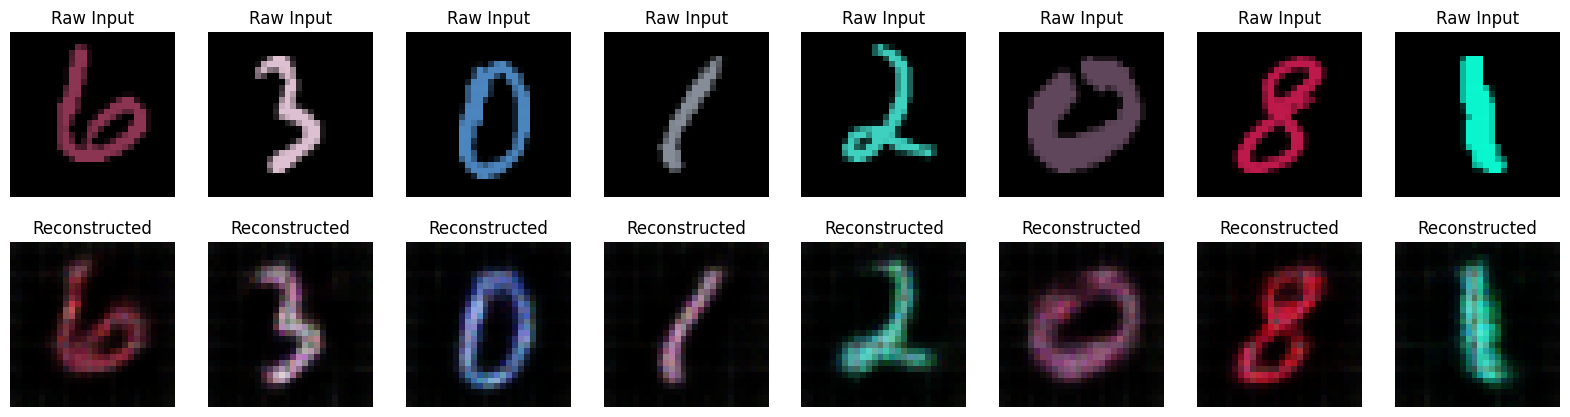

Epoch [5/10], Training Loss: 0.007028
Epoch [5/10], Validation Loss: 0.006434


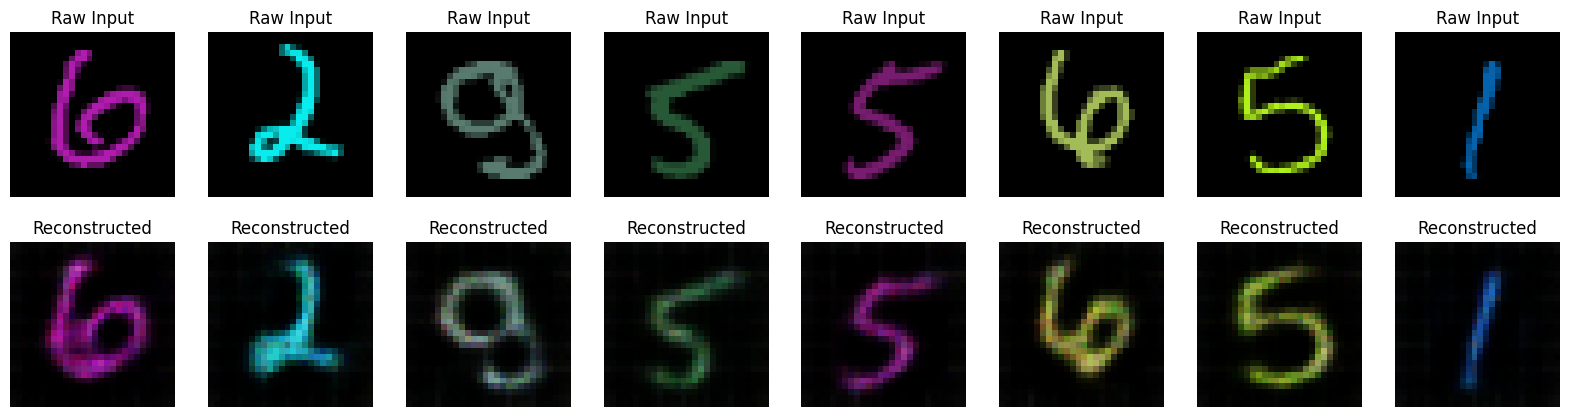

Epoch [6/10], Training Loss: 0.006018
Epoch [6/10], Validation Loss: 0.005631


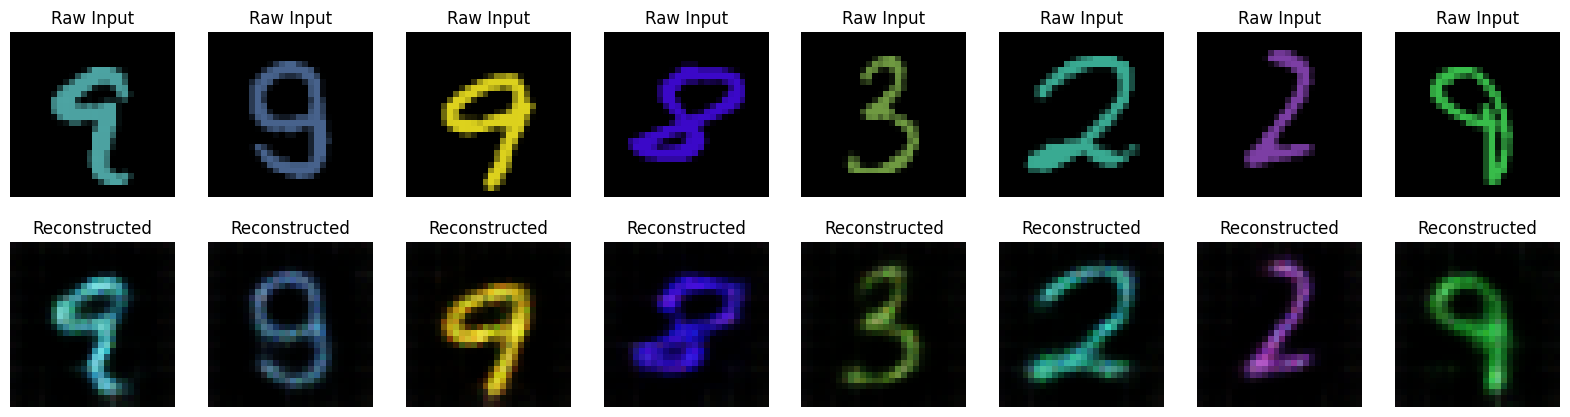

Epoch [7/10], Training Loss: 0.005369
Epoch [7/10], Validation Loss: 0.005271


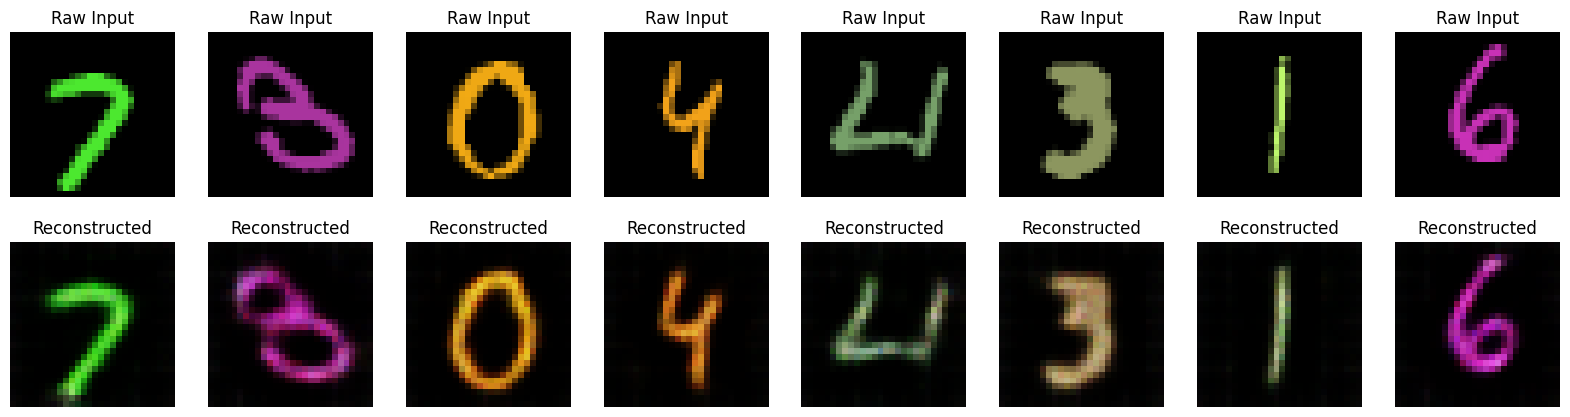

Epoch [8/10], Training Loss: 0.004979
Epoch [8/10], Validation Loss: 0.005007


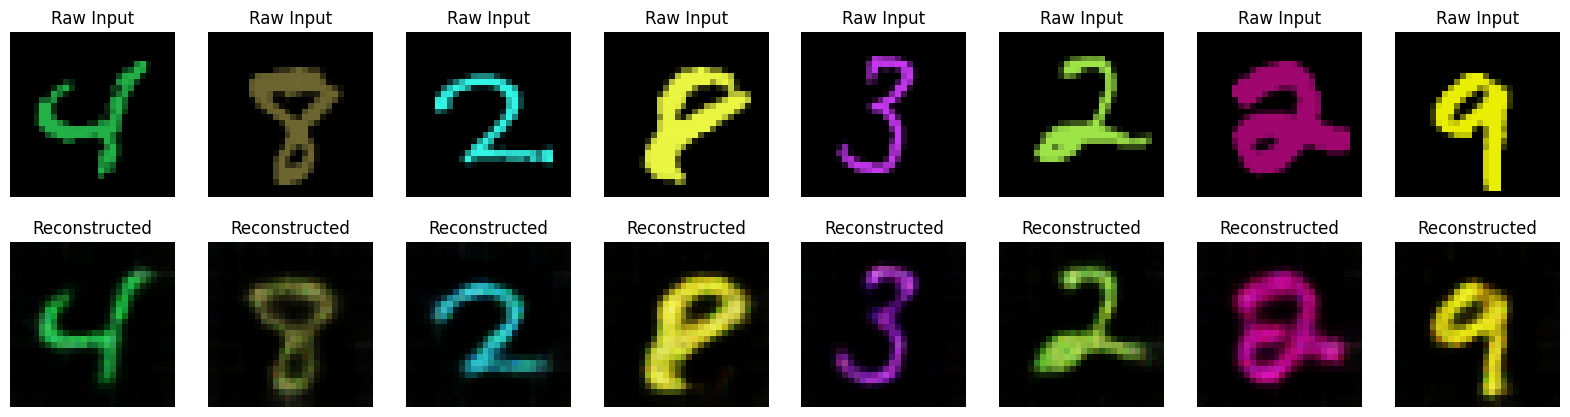

Epoch [9/10], Training Loss: 0.004751
Epoch [9/10], Validation Loss: 0.004702


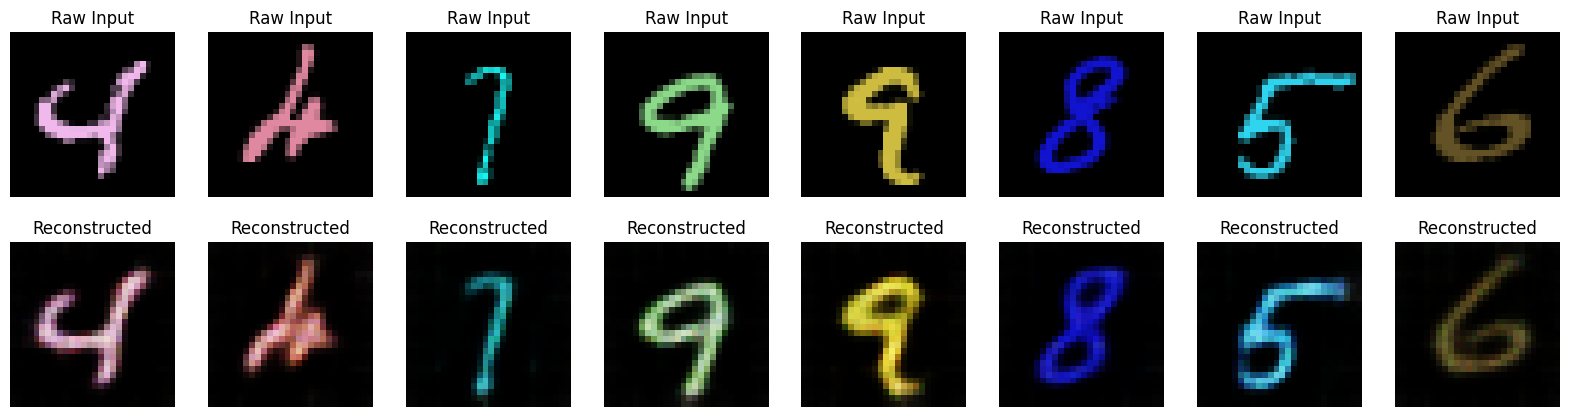

Epoch [10/10], Training Loss: 0.004580
Epoch [10/10], Validation Loss: 0.004480


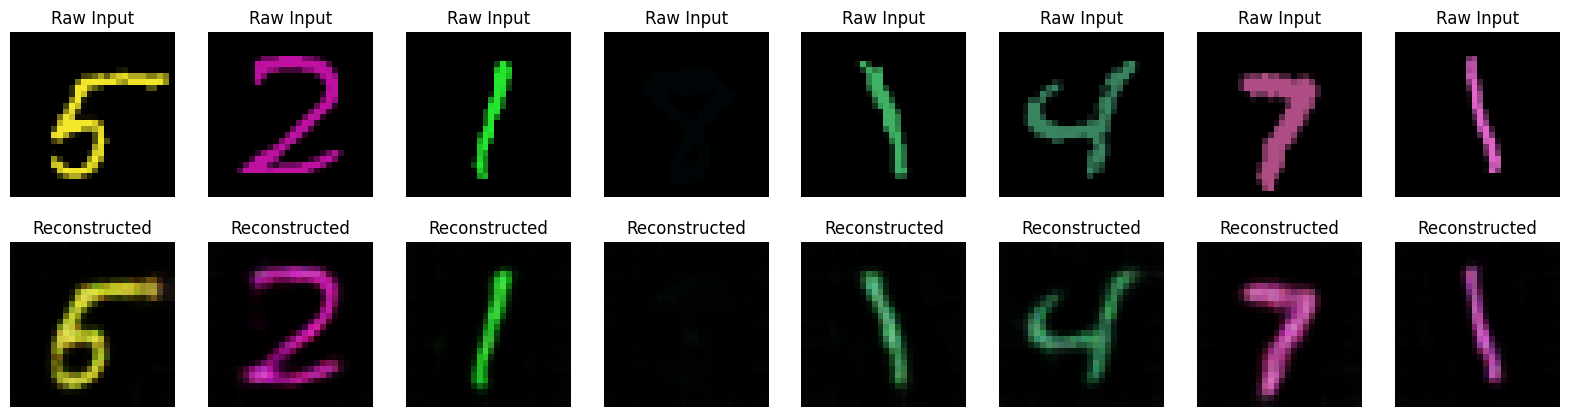

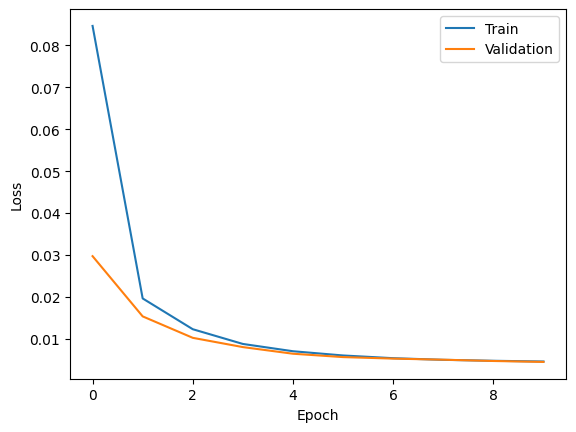

In [10]:
codebook_sizes = [5 ,15 , 25 , 35 , 45]
for codebook_size in codebook_sizes:
    print(f"codebook_size = {codebook_size}")
    vq_vae = VQVAE(input_channel = 3 , channel_sizes = [64, 64], latent_dim = 64, codebook_size = codebook_size, codebook_dim = 2 ).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(vq_vae.parameters(), lr=5e-4)

    num_epochs = 10
    lambda_co = 0.02
    codebooks = []
    train_losses = []
    valid_losses = []
    num_samples = 8


    for epoch in range(num_epochs): 
        vq_vae.train()
        running_loss = 0
        for idx, (inputs, _ ) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
            inputs = inputs.to(device)
            recon, latent_vector,quantized_vector  = vq_vae(inputs)
            loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
            loss.backward()
            optimizer.step()
            codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())
            running_loss += loss.item()

        # average loss during each epoch
        epoch_loss = running_loss / idx
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.6f}')

        vq_vae.eval()

        with torch.no_grad():
            validation_loss = 0
            for idx, (inputs, _ ) in enumerate(valid_loader):
                inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
                inputs = inputs.to(device)
                recon, latent_vector, quantized_vector = vq_vae(inputs)
                loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
                validation_loss += loss.item()

        validation_epoch_loss = validation_loss / idx
        valid_losses.append(validation_epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.6f}')
        with torch.no_grad():
            inputs,_ = next(iter(valid_loader))
            inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
            inputs = inputs.to(device)
            recons,_,_ = vq_vae(inputs)
            plt.figure(figsize=(5*num_samples//2, 5))
            samples = torch.randint(0, inputs.size(0), (num_samples,))
            for i, s in enumerate(samples):
                plt.subplot(2, num_samples, i + 1)
                plt.imshow(inputs[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Raw Input')
                plt.axis('off')

                plt.subplot(2, num_samples, i + 1 + num_samples)
                plt.imshow(recons[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')

            plt.show()

    # Plot Train & Validation Loss
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

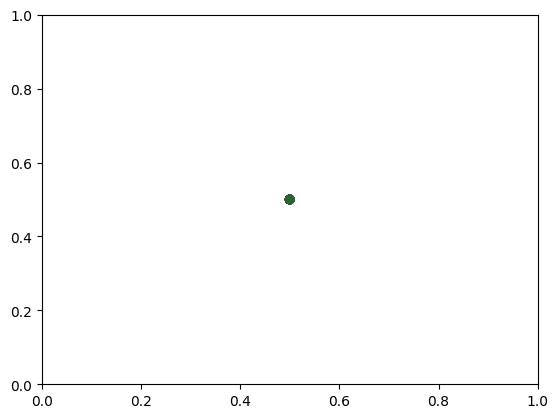

In [43]:
def generate_colors(codebook_size):
    colors1 = torch.linspace(0, 1, codebook_size)
    colors2 = colors1.flip(0)
    colors3 = torch.rand(codebook_size) / 2 + 0.5
    return torch.stack([colors1, colors2, colors3]).view(-1, 3)

def update_plot(frame, cbs, colors, ax):
    ax.clear()
    plt.scatter(cbs[frame * 10, :, 0], cbs[frame * 10, :, 1], c=1 - colors)
    plt.xlim([0, 1])
    plt.ylim([0, 1])



colors = generate_colors(codebook_size = 50)
cbs = torch.stack(codebooks)

fig, ax = plt.subplots()

ani = FuncAnimation(fig, lambda frame: update_plot(frame, cbs, colors, ax),
                    frames=cbs.shape[0] // 10, repeat=False)

ani.save('second.gif', writer='pillow', fps=30)
gif_path = 'second.gif'
html_code = f'<img src="{gif_path}" alt="animation">'
display(HTML(html_code))

codebook_dim = 5
Epoch [1/5], Training Loss: 0.119928
Epoch [1/5], Validation Loss: 0.092689


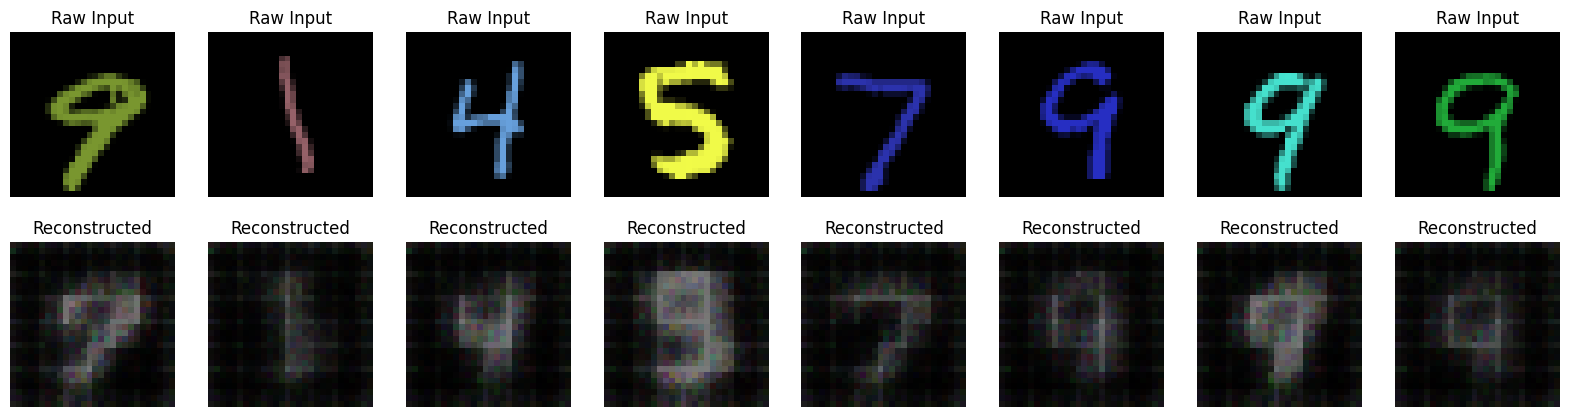

Epoch [2/5], Training Loss: 0.084027
Epoch [2/5], Validation Loss: 0.085713


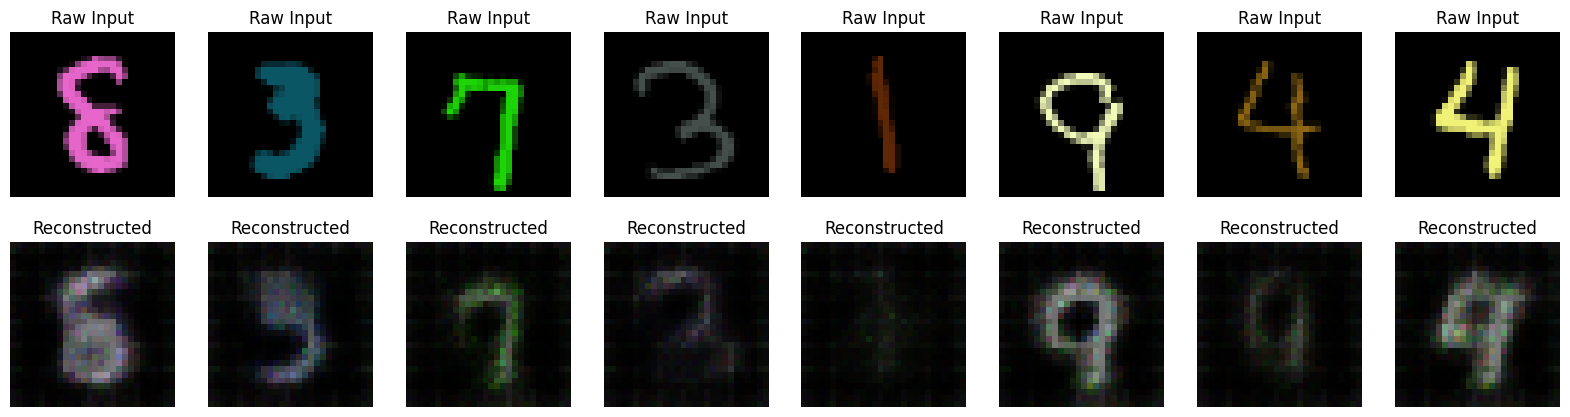

Epoch [3/5], Training Loss: 0.084601
Epoch [3/5], Validation Loss: 0.088273


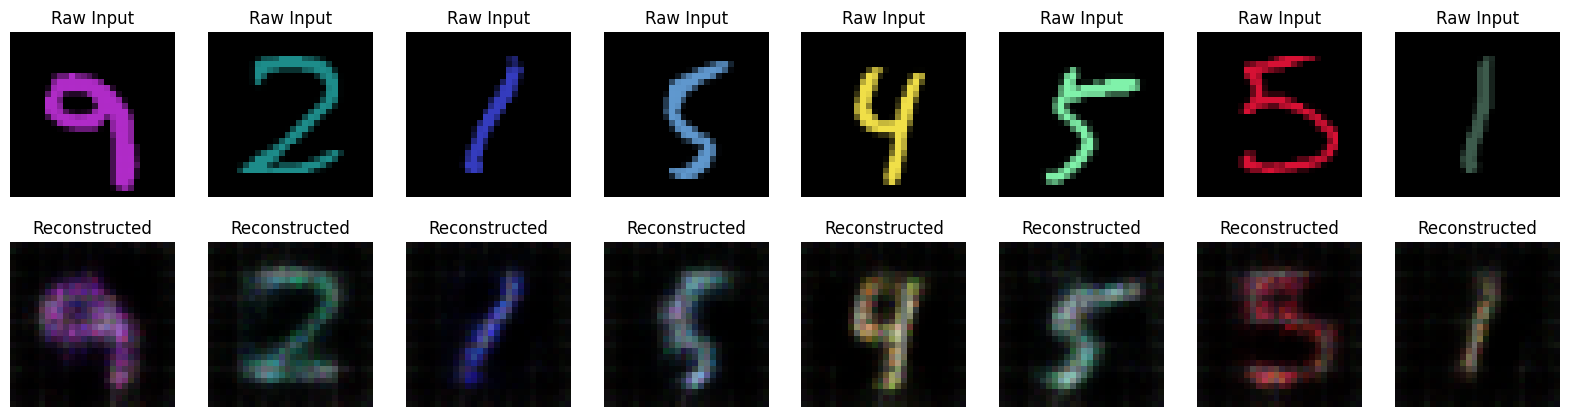

Epoch [4/5], Training Loss: 0.086576
Epoch [4/5], Validation Loss: 0.089891


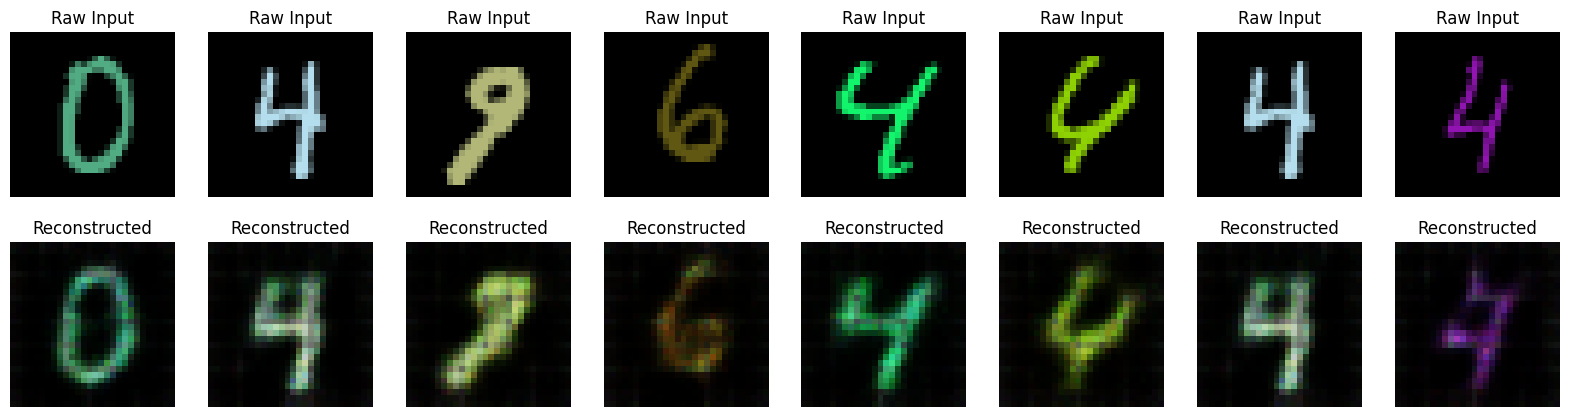

Epoch [5/5], Training Loss: 0.088218
Epoch [5/5], Validation Loss: 0.090177


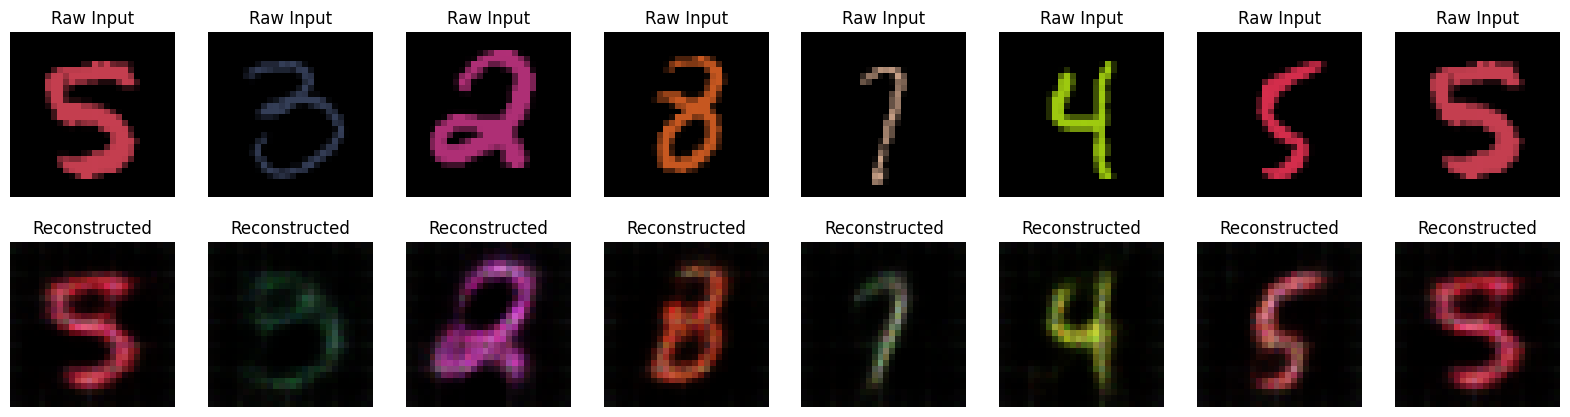

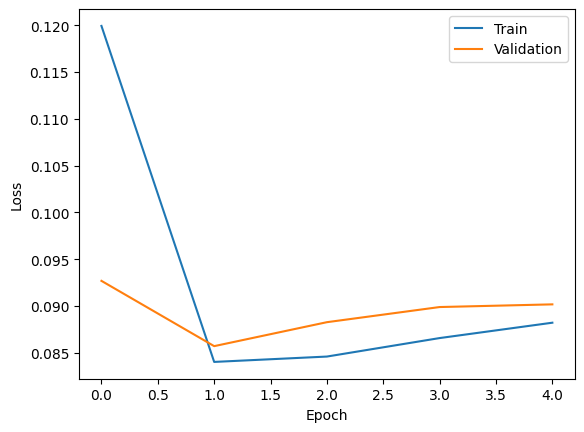

codebook_dim = 15
Epoch [1/5], Training Loss: 0.130049
Epoch [1/5], Validation Loss: 0.119784


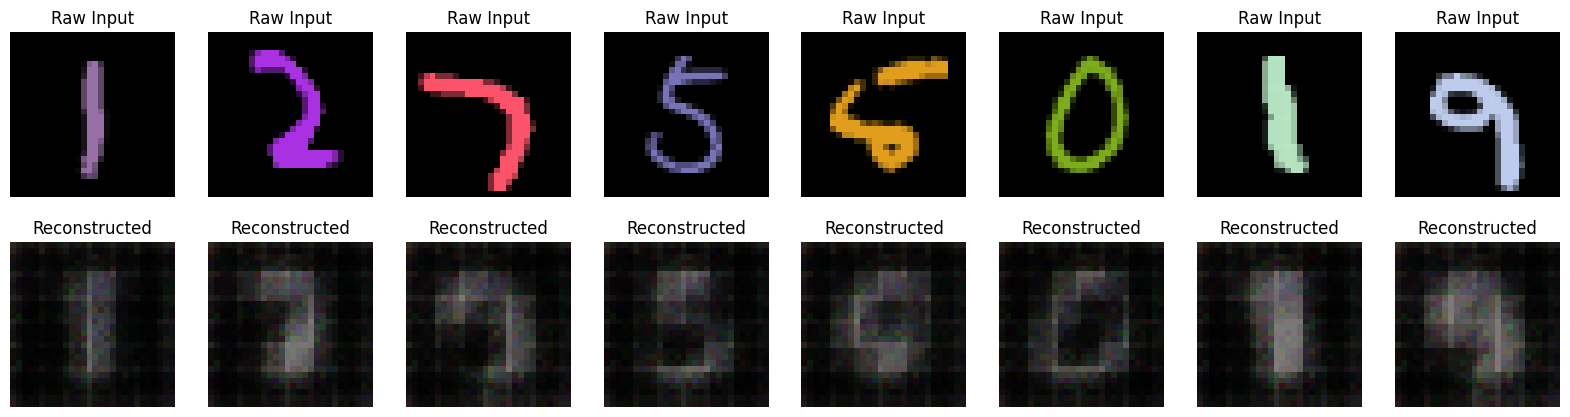

Epoch [2/5], Training Loss: 0.109860
Epoch [2/5], Validation Loss: 0.112975


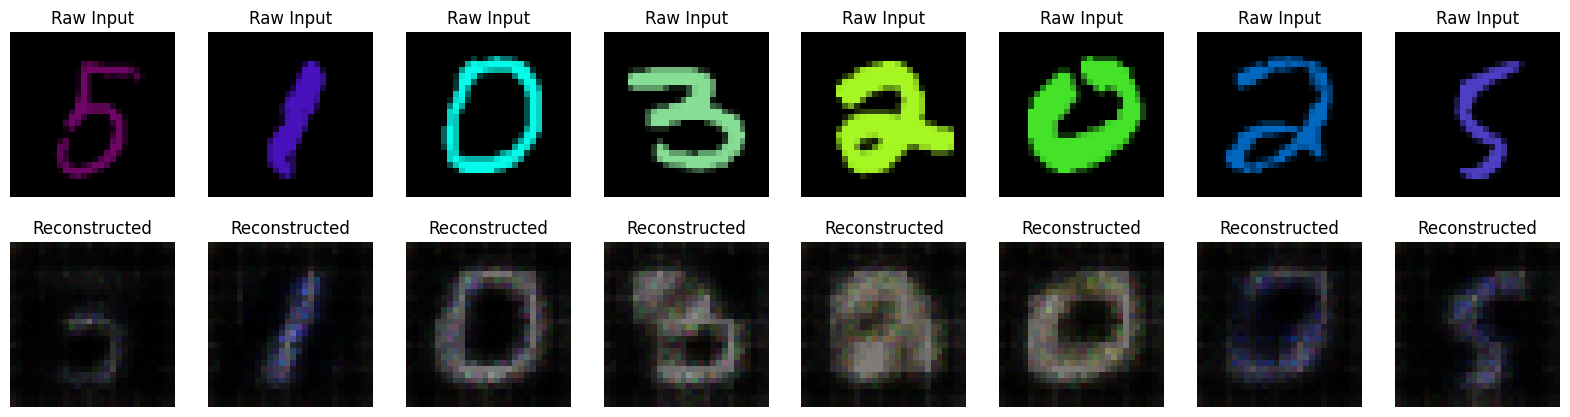

Epoch [3/5], Training Loss: 0.111509
Epoch [3/5], Validation Loss: 0.119392


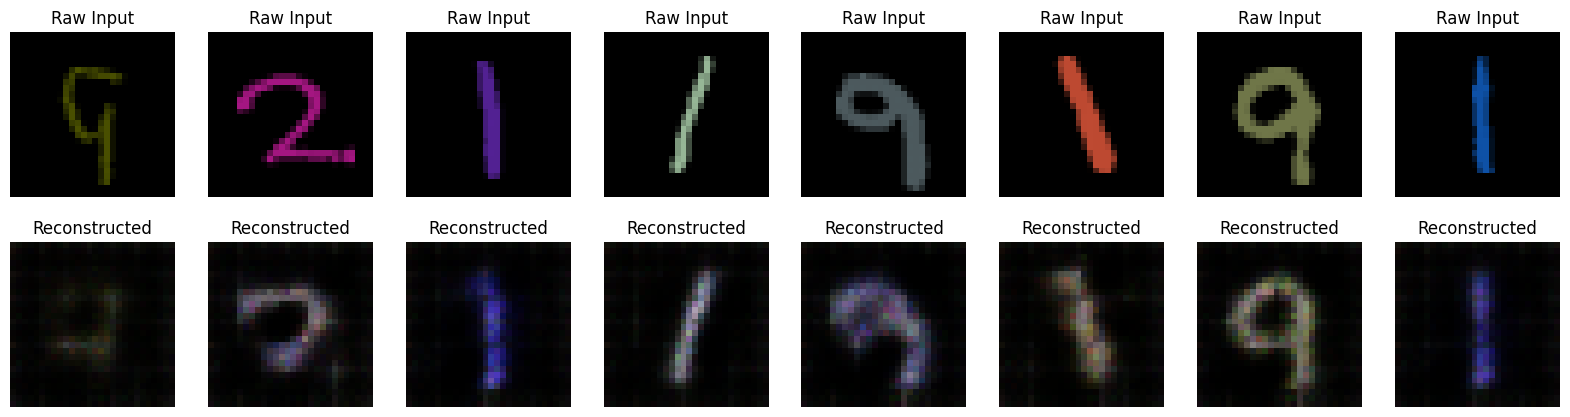

Epoch [4/5], Training Loss: 0.118667
Epoch [4/5], Validation Loss: 0.124100


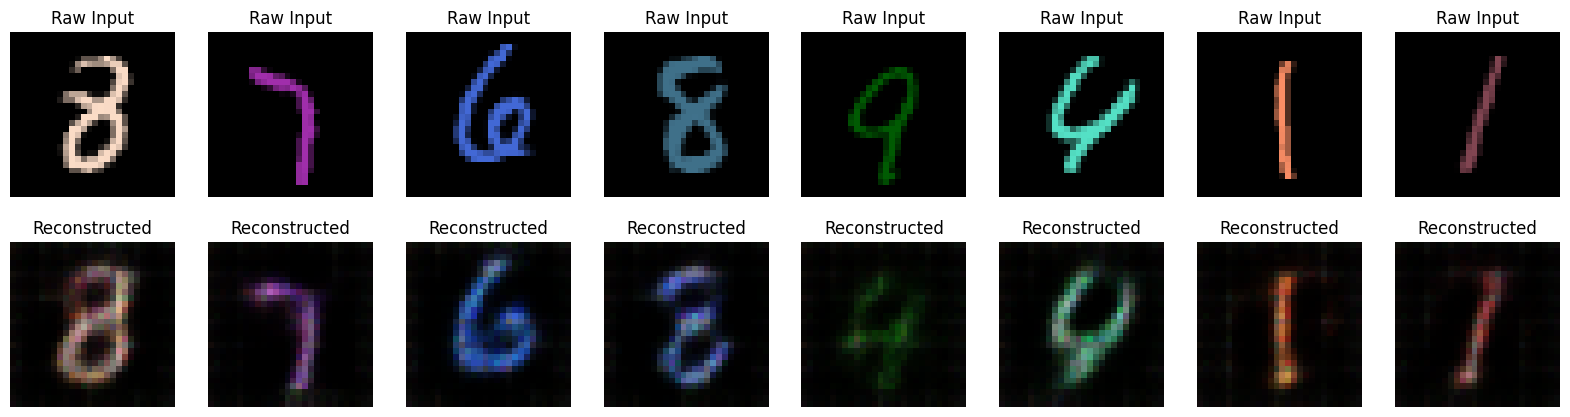

Epoch [5/5], Training Loss: 0.122319
Epoch [5/5], Validation Loss: 0.126453


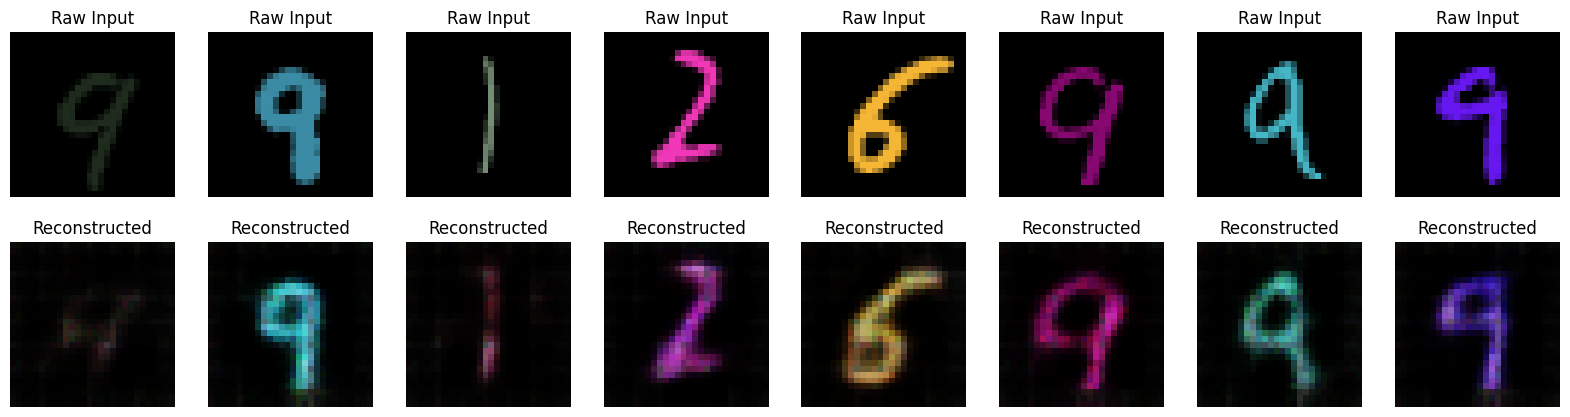

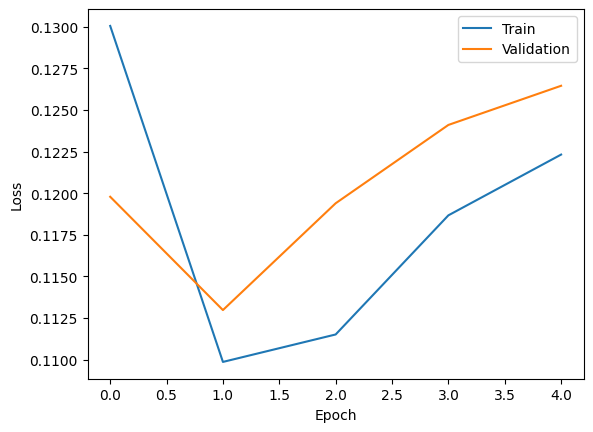

codebook_dim = 25
Epoch [1/5], Training Loss: 0.131756
Epoch [1/5], Validation Loss: 0.145941


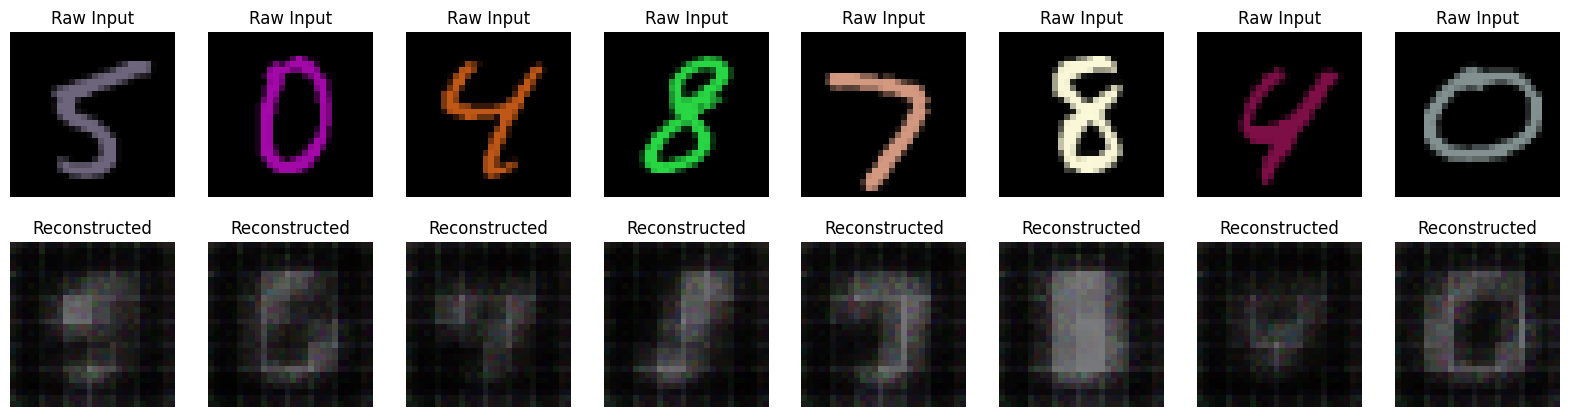

Epoch [2/5], Training Loss: 0.126084
Epoch [2/5], Validation Loss: 0.123809


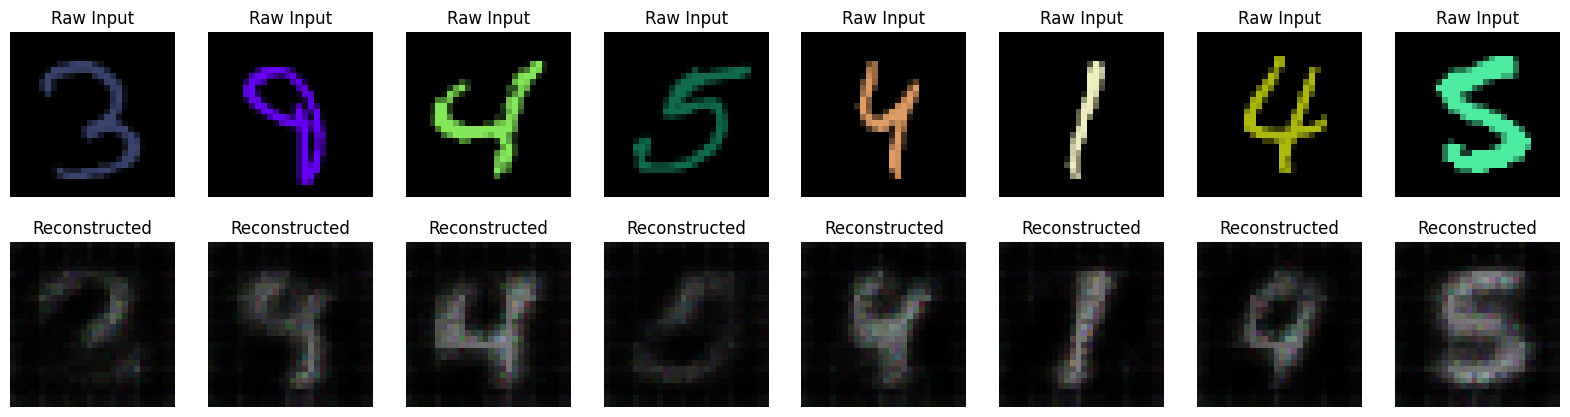

Epoch [3/5], Training Loss: 0.123900
Epoch [3/5], Validation Loss: 0.127551


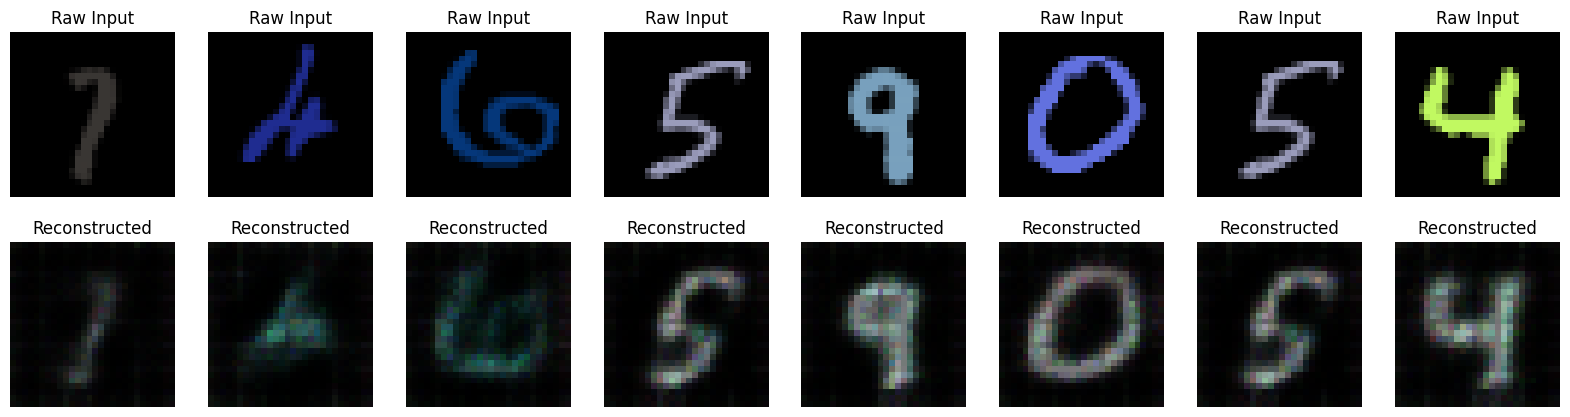

Epoch [4/5], Training Loss: 0.128581
Epoch [4/5], Validation Loss: 0.136972


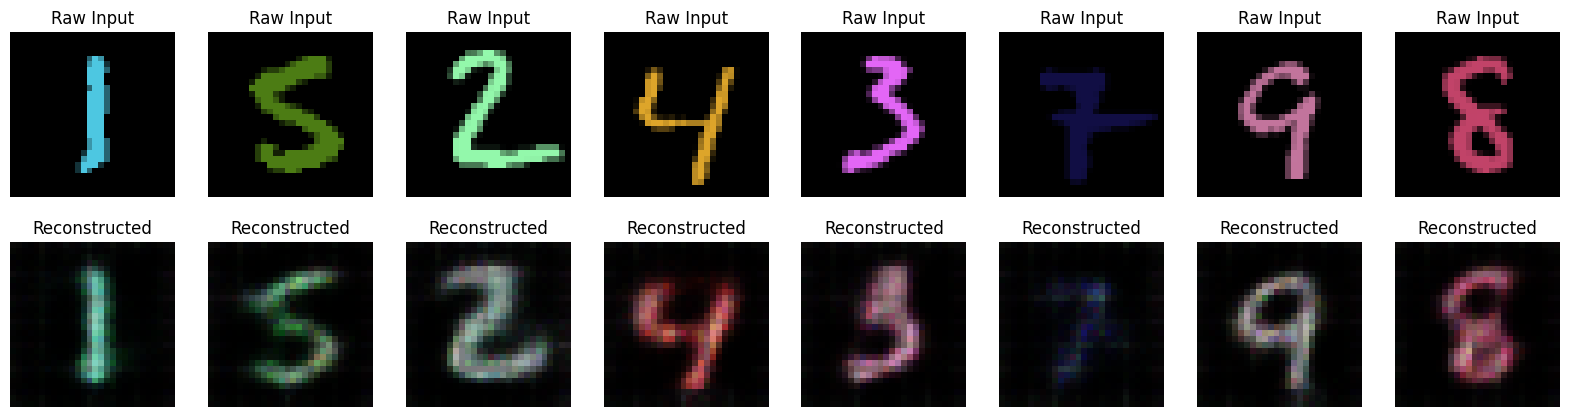

Epoch [5/5], Training Loss: 0.134943
Epoch [5/5], Validation Loss: 0.139701


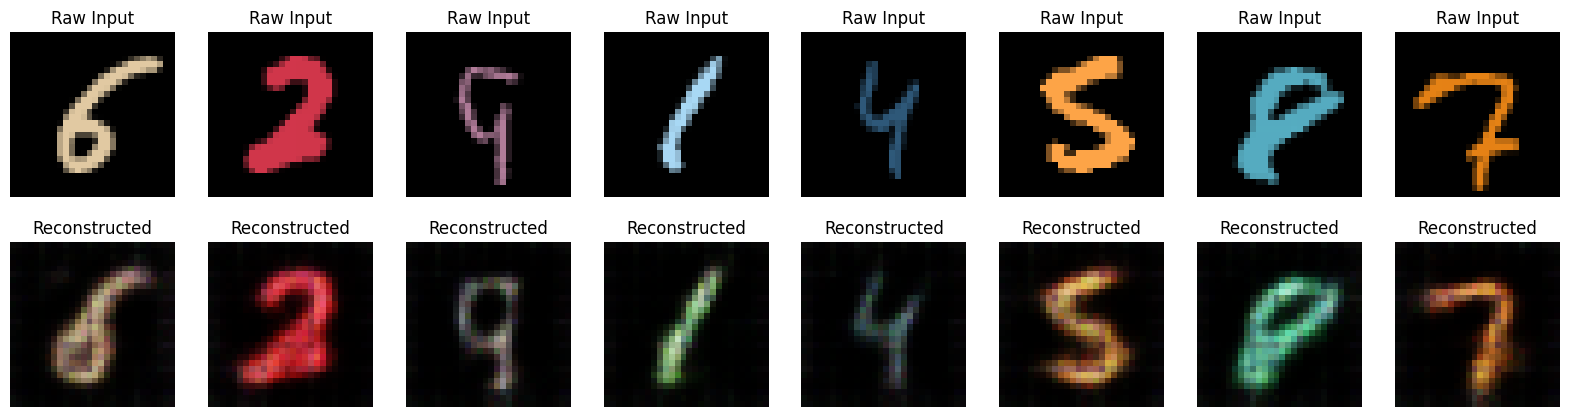

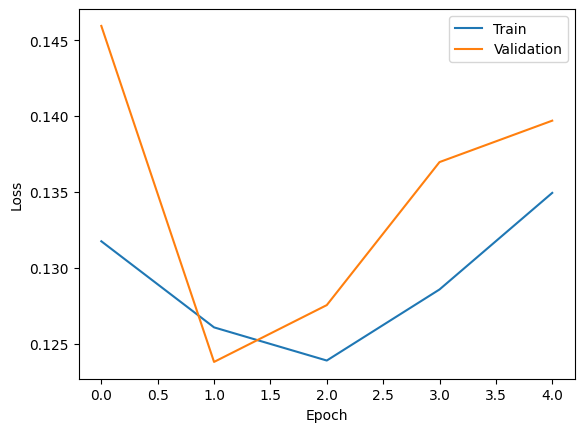

codebook_dim = 35
Epoch [1/5], Training Loss: 0.129577
Epoch [1/5], Validation Loss: 0.146048


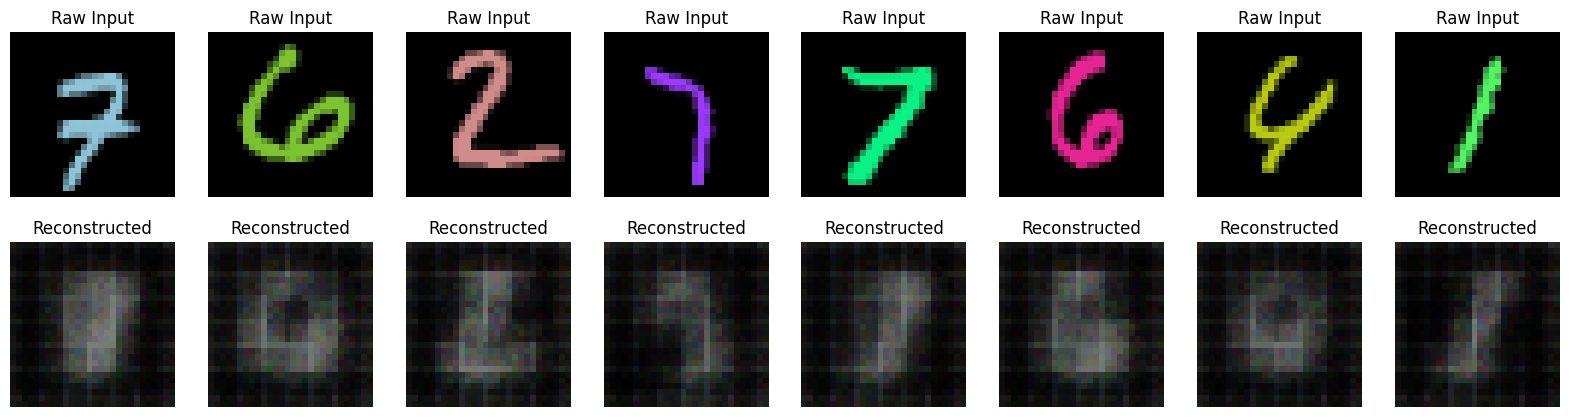

Epoch [2/5], Training Loss: 0.127871
Epoch [2/5], Validation Loss: 0.127801


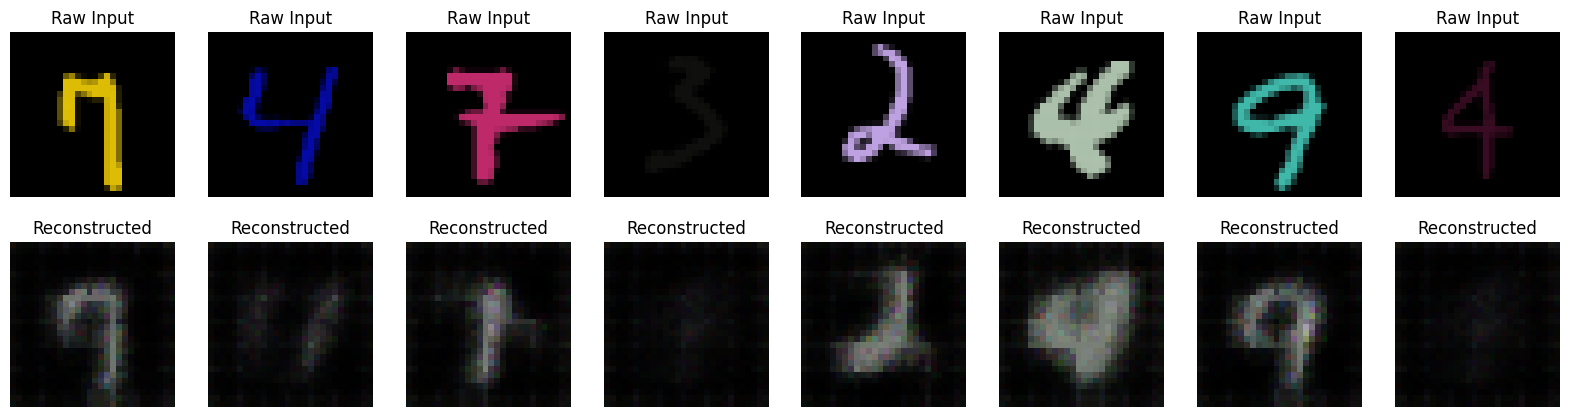

Epoch [3/5], Training Loss: 0.122982
Epoch [3/5], Validation Loss: 0.130461


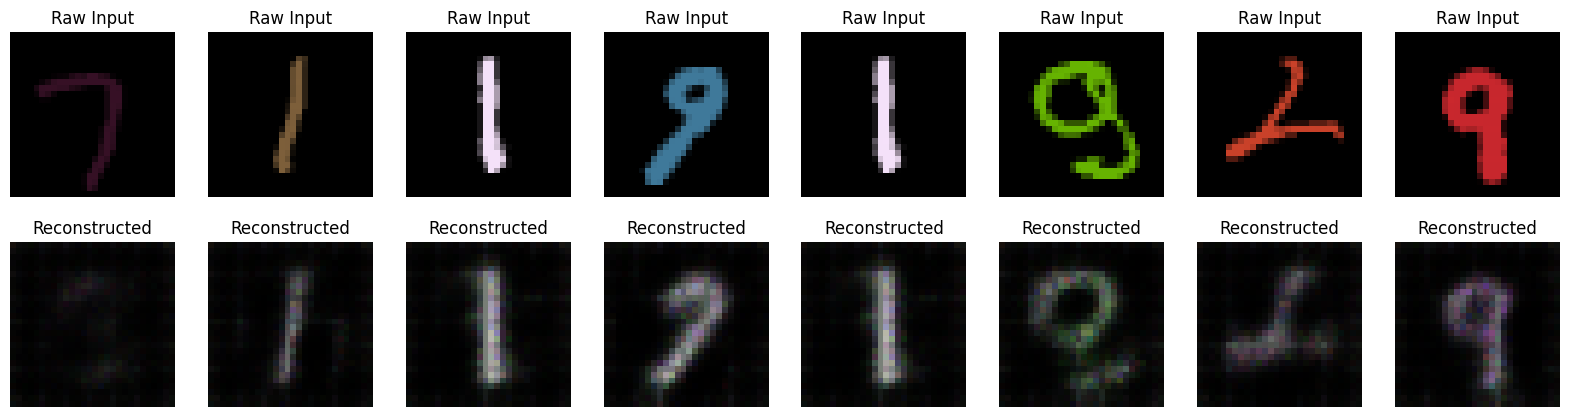

Epoch [4/5], Training Loss: 0.128388
Epoch [4/5], Validation Loss: 0.136429


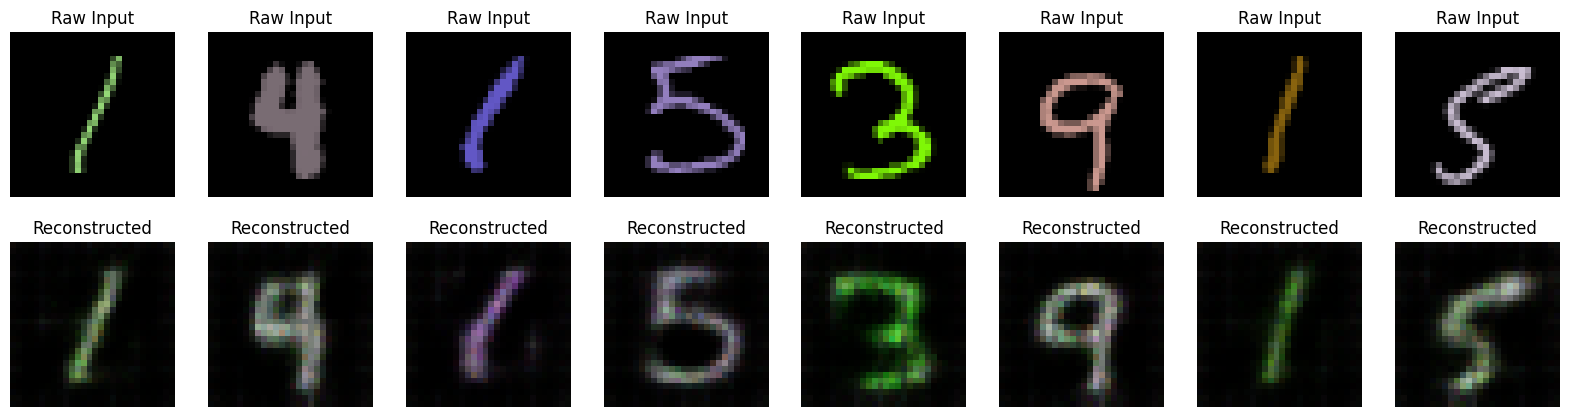

Epoch [5/5], Training Loss: 0.135098
Epoch [5/5], Validation Loss: 0.139029


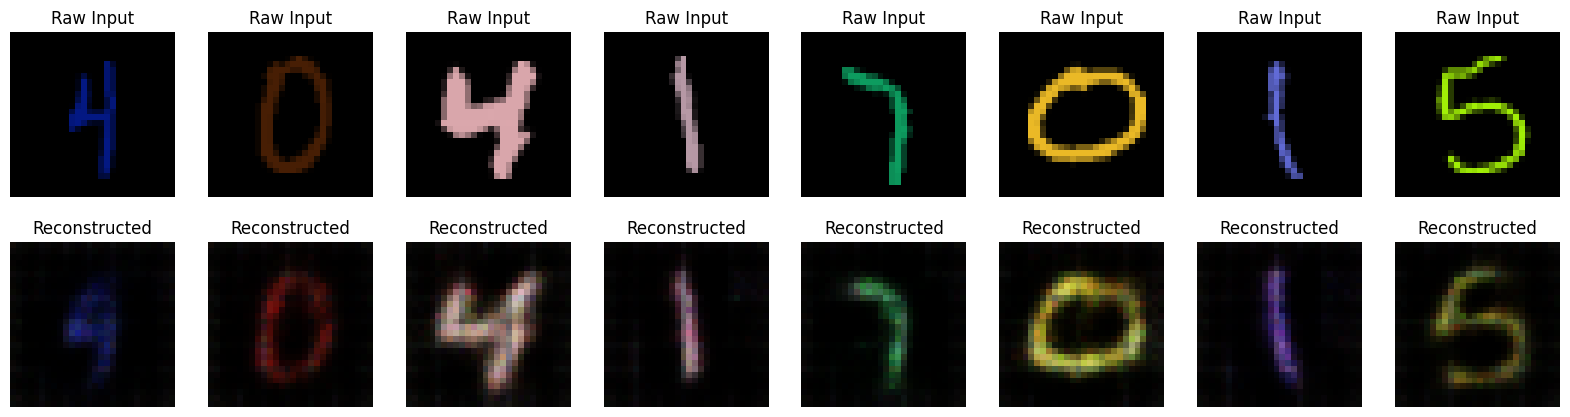

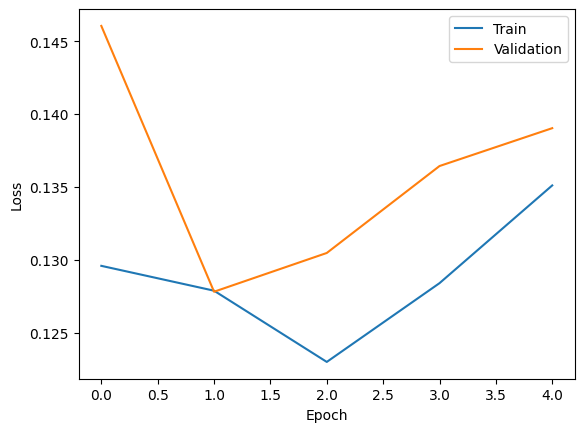

codebook_dim = 45
Epoch [1/5], Training Loss: 0.118652
Epoch [1/5], Validation Loss: 0.167199


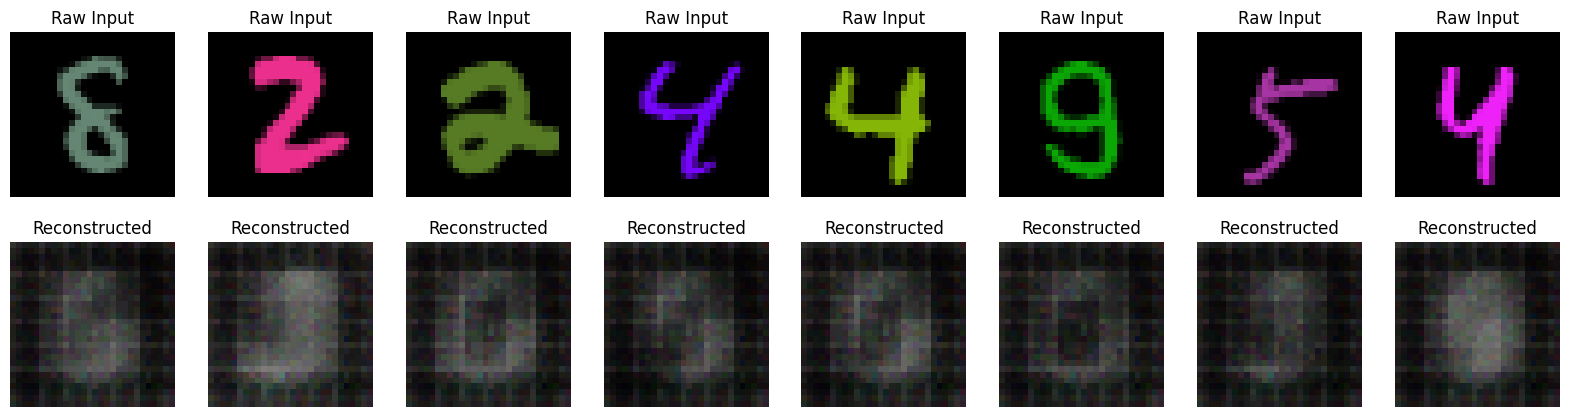

Epoch [2/5], Training Loss: 0.138099
Epoch [2/5], Validation Loss: 0.130479


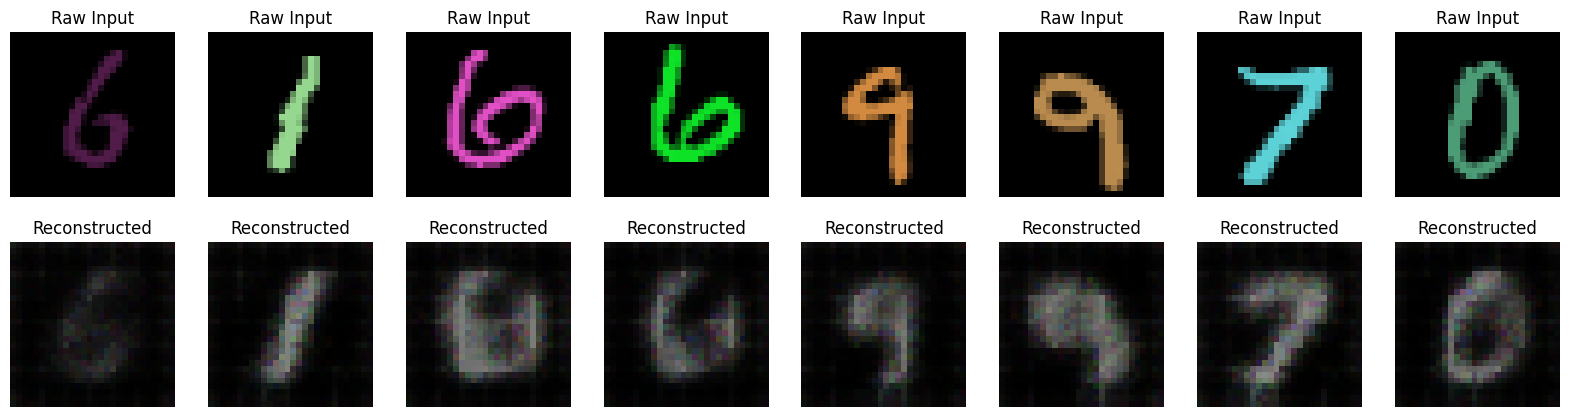

Epoch [3/5], Training Loss: 0.122121
Epoch [3/5], Validation Loss: 0.122088


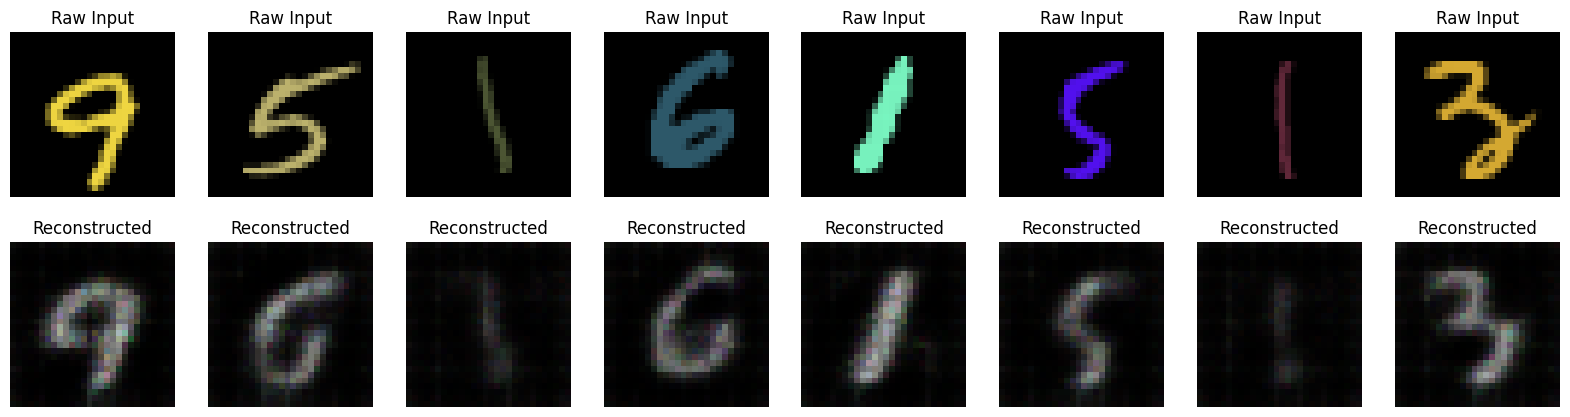

Epoch [4/5], Training Loss: 0.119202
Epoch [4/5], Validation Loss: 0.125942


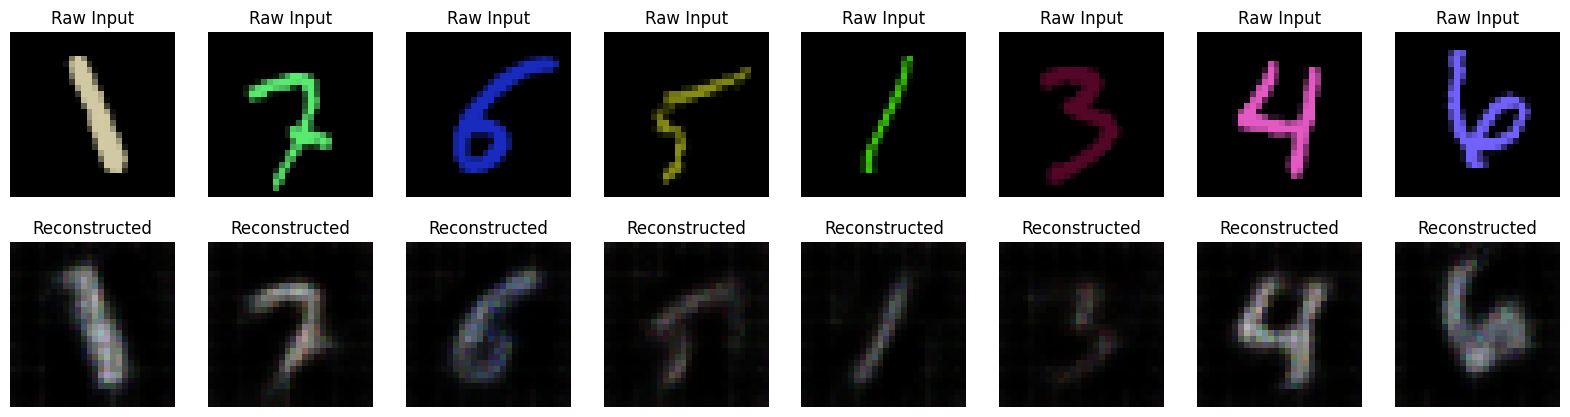

Epoch [5/5], Training Loss: 0.121187
Epoch [5/5], Validation Loss: 0.124022


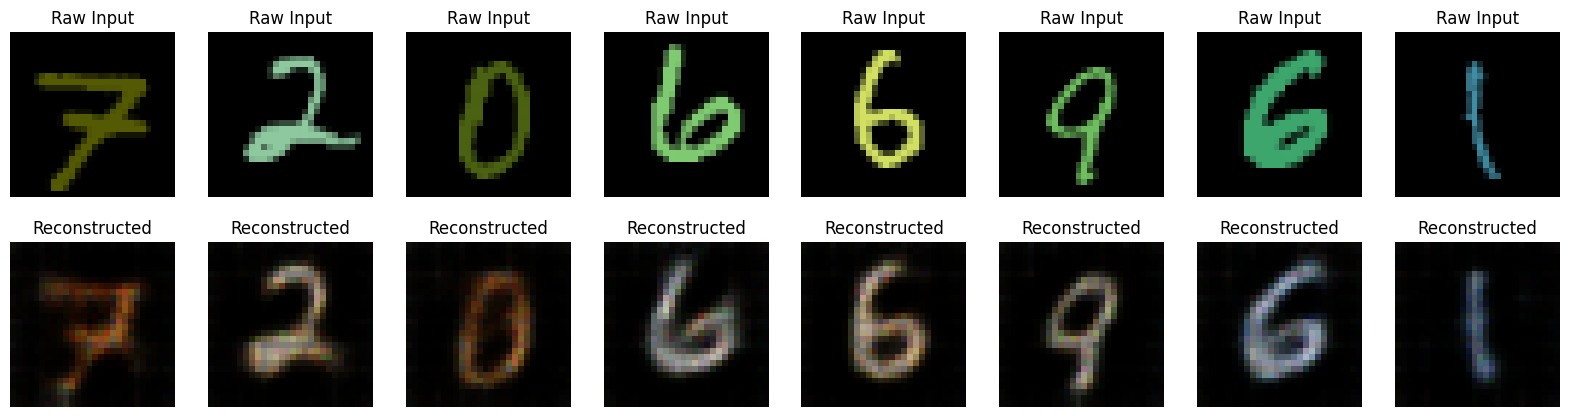

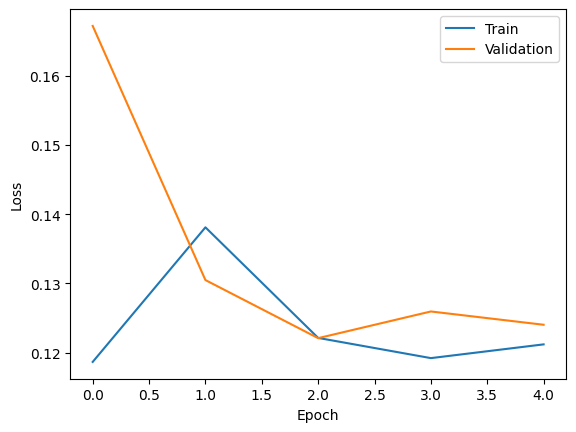

In [14]:
codebook_dims = [5,15,25,35,45]
for codebook_dim in codebook_dims:
    print(f"codebook_dim = {codebook_dim}")
    vq_vae = VQVAE(input_channel = 3 , channel_sizes = [64, 64], latent_dim = 64, codebook_size = 3, codebook_dim = codebook_dim ).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(vq_vae.parameters(), lr=5e-4)
    num_epochs = 5
    lambda_co = 0.02
    codebooks = []
    train_losses = []
    valid_losses = []
    num_samples = 8
    for epoch in range(num_epochs): 
        vq_vae.train()
        running_loss = 0
        for idx, (inputs, _ ) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
            inputs = inputs.to(device)
            recon, latent_vector,quantized_vector  = vq_vae(inputs)
            loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
            loss.backward()
            optimizer.step()
            codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())
            running_loss += loss.item()

        # average loss during each epoch
        epoch_loss = running_loss / idx
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.6f}')

        vq_vae.eval()

        with torch.no_grad():
            validation_loss = 0
            for idx, (inputs, _ ) in enumerate(valid_loader):
                inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
                inputs = inputs.to(device)
                recon, latent_vector, quantized_vector = vq_vae(inputs)
                loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
                validation_loss += loss.item()

        validation_epoch_loss = validation_loss / idx
        valid_losses.append(validation_epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.6f}')
        with torch.no_grad():
            inputs,_ = next(iter(valid_loader))
            inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
            inputs = inputs.to(device)
            recons,_,_ = vq_vae(inputs)
            plt.figure(figsize=(5*num_samples//2, 5))
            samples = torch.randint(0, inputs.size(0), (num_samples,))
            for i, s in enumerate(samples):
                plt.subplot(2, num_samples, i + 1)
                plt.imshow(inputs[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Raw Input')
                plt.axis('off')

                plt.subplot(2, num_samples, i + 1 + num_samples)
                plt.imshow(recons[s].permute(1, 2, 0).cpu(), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')

            plt.show()

    # Plot Train & Validation Loss
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

 همانطور که قابل مشاهده است با افزایش سایز کدبوک به مراتب نمونه های تولیدی بهتری میگیریم در مقایسه با زمانی که ابعاد کد بوک را افزایش می دهیم.  
 همچنین  از مجموعه مقادیر تابع هزینه در بخش اموزش و ارزشیابی نیز  قابل استنباط است.
 برای توضیح بهتر افزایش بعد رفتاری غیر خطی داراست.و اموزش نتورک را مشکل رو به رو می نماید.